# Titanic spaceship
## Introduction

Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

cf [here](https://www.kaggle.com/competitions/spaceship-titanic)

In [1]:
# imports

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# options

custom_colors = [
    (100/255, 108/255, 116/255),   # nevada
    (228/255, 12/255, 33/255),     # red-ribbon
    (68/255, 68/255, 76/255),      # abbey
    (172/255, 28/255, 44/255),     # roof-terracotta 
]
custom_palette = sns.color_palette(custom_colors)
custom_palette

[(0.39215686274509803, 0.4235294117647059, 0.4549019607843137),
 (0.8941176470588236, 0.047058823529411764, 0.12941176470588237),
 (0.26666666666666666, 0.26666666666666666, 0.2980392156862745),
 (0.6745098039215687, 0.10980392156862745, 0.17254901960784313)]

## Read data

In [3]:
train_df = pd.read_csv("./samples/train.csv")
train_df['Transported'] = train_df['Transported'].astype(int)
test_df = pd.read_csv("./samples/test.csv")
df = pd.concat([train_df, test_df], axis=0)
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0.0
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1.0
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0.0
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0.0
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1.0


## Explaination

- train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.
   - ```PassengerId``` - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
   - ```HomePlanet``` - The planet the passenger departed from, typically their planet of permanent residence.
   - ```CryoSleep``` - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
   - ```Cabin``` - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
   - ```Destination``` - The planet the passenger will be debarking to.
   - ```Age``` - The age of the passenger.
   - ```VIP``` - Whether the passenger has paid for special VIP service during the voyage.
   - ```RoomService, FoodCourt, ShoppingMall, Spa, VRDeck``` - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
   - ```Name``` - The first and last names of the passenger.
   - ```Transported``` - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.
- test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.
- sample_submission.csv - A submission file in the correct format.
   - ```PassengerId``` - Id for each passenger in the test set.
   - ```Transported``` - The target. For each passenger, predict either True or False.

## Summary

we'll see if some data is missing or duplicated

In [4]:
def summary(df):
    print(f"Dataset has {df.shape[1]} features and {df.shape[0]} examples.")
    summary = pd.DataFrame(index=df.columns)
    summary["Unique"] = df.nunique().values
    summary["Missing"] = df.isnull().sum().values
    summary["Duplicated"] = df.duplicated().sum()
    summary["Types"] = df.dtypes
    return summary
summary(df)

Dataset has 14 features and 12970 examples.


,Unique,Missing,Duplicated,Types
PassengerId,12970,0,0,object
HomePlanet,3,288,0,object
CryoSleep,2,310,0,object
Cabin,9825,299,0,object
Destination,3,274,0,object
Age,80,270,0,float64
VIP,2,296,0,object
RoomService,1578,263,0,float64
FoodCourt,1953,289,0,float64
ShoppingMall,1367,306,0,float64


In [5]:
# repartition of values in our dataset
transported_count = df[(df["Transported"] == True)]["Transported"].count()
untransported_count = df[(df["Transported"] == False)]["Transported"].count()
print(f"Transported passengers count: {transported_count} ({(transported_count / df.shape[0]) * 100 :.2f}%)")
print(f"Untransported passengers count: {untransported_count} ({(untransported_count / df.shape[0]) * 100 :.2f}%)")

Transported passengers count: 4378 (33.75%)
Untransported passengers count: 4315 (33.27%)


## Wrangling data

we have to improve our data, replace missing values...

### PassengerId

we can get ```gggg```, the passenger group and convert it to group size to estimate a new parameter, the correlation with the ```Transported``` parameter will be more efficient

In [6]:
group = df['PassengerId'].apply(lambda x: x.split('_')[0]).value_counts().to_dict()
df['Group_size'] = df['PassengerId'].apply(lambda x: group[x.split('_')[0]])
df.set_index('PassengerId', inplace=True)
df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group_size
PassengerId,,,,,,,,,,,,,,
0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0.0,1
0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1.0,1
0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0.0,2
0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0.0,2
0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1.0,1


### HomePlanet

We have 201 missing values for homeplanet, we can get the average of existing values and apply to them

In [7]:
df["HomePlanet"].value_counts()

Earth     6865
Europa    3133
Mars      2684
Name: HomePlanet, dtype: int64

In [8]:
avg = df["HomePlanet"].value_counts()
percentage = avg.values / sum(avg.values)
percentage

array([0.5413184 , 0.24704305, 0.21163854])

In [9]:
# replace NaN values by random existing value
df.loc[df['HomePlanet'].isna(), 'HomePlanet'] = np.random.choice(avg.index, df['HomePlanet'].isna().sum(), p=percentage)

### CryoSleep
We have 217 missing values for CryoSleep, we can define those like False

In [10]:
df["CryoSleep"].fillna(False, inplace=True)
df['CryoSleep'] = df['CryoSleep'].astype(int) # bool to int

### Cabin
We have 199 missing values, we have to split this data in deck/num/side

In [11]:
df[["CabinDeck", "CabinNum", "CabinSide"]] = df["Cabin"].str.split("/", n=2, expand=True)
df.head()

,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group_size,CabinDeck,CabinNum,CabinSide
PassengerId,,,,,,,,,,,,,,,,,
0001_01,Europa,0,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0.0,1,B,0,P
0002_01,Earth,0,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1.0,1,F,0,S
0003_01,Europa,0,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0.0,2,A,0,S
0003_02,Europa,0,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0.0,2,A,0,S
0004_01,Earth,0,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1.0,1,F,1,S


### Cabin-Deck
replace NaN value with most available value

In [12]:
df["CabinDeck"].value_counts()

F    4239
G    3781
E    1323
B    1141
C    1102
D     720
A     354
T      11
Name: CabinDeck, dtype: int64

In [13]:
# Generate random choices between 'F' and 'G'
# Replace NaN values with random choices
df['CabinDeck'] = df['CabinDeck'].fillna(df['CabinDeck'].apply(lambda x: np.random.choice(['F', 'G']) if pd.isna(x) else x))
df["CabinDeck"].value_counts()

F    4387
G    3932
E    1323
B    1141
C    1102
D     720
A     354
T      11
Name: CabinDeck, dtype: int64

### Cabin-num
replace NaN values with mean values

In [14]:
df["CabinNum"].value_counts()

82      34
4       28
56      28
95      27
31      27
        ..
1848     1
1847     1
1846     1
1844     1
1890     1
Name: CabinNum, Length: 1894, dtype: int64

In [15]:
mean = round(df["CabinNum"].astype(float).mean())
print(mean)
df["CabinNum"].fillna(mean, inplace=True)
df["CabinNum"] = df["CabinNum"].astype(int)
df["CabinNum"]

604


PassengerId
0001_01       0
0002_01       0
0003_01       0
0003_02       0
0004_01       1
           ... 
9266_02    1496
9269_01     604
9271_01     296
9273_01     297
9277_01    1498
Name: CabinNum, Length: 12970, dtype: int32

### Cabin-side

replace NaN values with random value between S or P

In [16]:
# Generate random choices between 'F' and 'G'
print(df["CabinSide"].value_counts())
# Replace NaN values with random choices
df['CabinSide'] = df['CabinSide'].fillna(df['CabinSide'].apply(lambda x: np.random.choice(['S', 'P']) if pd.isna(x) else x))

df["CabinSide"] = df["CabinSide"].map({'S': 0, 'P': 1})
df["CabinSide"]

S    6381
P    6290
Name: CabinSide, dtype: int64


PassengerId
0001_01    1
0002_01    0
0003_01    0
0003_02    0
0004_01    0
          ..
9266_02    0
9269_01    0
9271_01    1
9273_01    1
9277_01    0
Name: CabinSide, Length: 12970, dtype: int64

In [17]:
df.drop("Cabin", axis=1, inplace=True)
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Group_size,CabinDeck,CabinNum,CabinSide
PassengerId,,,,,,,,,,,,,,,,
0001_01,Europa,0,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0.0,1,B,0,1
0002_01,Earth,0,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1.0,1,F,0,0
0003_01,Europa,0,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0.0,2,A,0,0
0003_02,Europa,0,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0.0,2,A,0,0
0004_01,Earth,0,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1.0,1,F,1,0


### Destination

we have 182 missing values, let's replace them with destinations average

In [18]:
df["Destination"].value_counts()

TRAPPIST-1e      8871
55 Cancri e      2641
PSO J318.5-22    1184
Name: Destination, dtype: int64

In [19]:
avg = df["Destination"].value_counts()
percentage = avg.values / sum(avg.values)
percentage

array([0.69872401, 0.20801827, 0.09325772])

In [20]:
df.loc[df['Destination'].isna(), 'Destination'] = np.random.choice(avg.index, df['Destination'].isna().sum(), p=percentage)

### Age
we have 179 missing values, let's replace them with mean

In [21]:
age_mean = round(df["Age"].mean())
age_mean

29

In [22]:
df["Age"].fillna(mean, inplace=True)

### VIP
we have 203 missing values, let's replace them with False

In [23]:
df["VIP"].fillna(False, inplace=True)
df["VIP"] = df["VIP"].astype(int)

### Total amount
we concat RoomService, FoodCourt, ShoppingMall, Spa, VRDeck to get the total amount of passsenger amenities

In [24]:
## replaces missing values with mean
## roomService
room_mean = round(df["RoomService"].mean())
print(f"RoomService mean: {room_mean}€")
df["RoomService"].fillna(room_mean, inplace=True)
## FoodCourt
food_mean = round(df["FoodCourt"].mean())
print(f"FoodCourt mean: {food_mean}€")
df["FoodCourt"].fillna(food_mean, inplace=True)
## ShoppingMail
shop_mean = round(df["ShoppingMall"].mean())
print(f"ShoppingMall mean: {shop_mean}€")
df["ShoppingMall"].fillna(shop_mean, inplace=True)
## Spa
spa_mean = round(df["Spa"].mean())
print(f"Spa mean: {spa_mean}€")
df["Spa"].fillna(spa_mean, inplace=True)
## VRDeck
vr_mean = round(df["VRDeck"].mean())
print(f"VR mean: {vr_mean}€")
df["VRDeck"].fillna(vr_mean, inplace=True)

RoomService mean: 223€
FoodCourt mean: 452€
ShoppingMall mean: 175€
Spa mean: 308€
VR mean: 307€


In [25]:
df["Total_amount"] = df[["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"]].sum(axis=1)
df.drop(["RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"], axis=1, inplace=True)
df.head()

,HomePlanet,CryoSleep,Destination,Age,VIP,Name,Transported,Group_size,CabinDeck,CabinNum,CabinSide,Total_amount
PassengerId,,,,,,,,,,,,
0001_01,Europa,0,TRAPPIST-1e,39.0,0,Maham Ofracculy,0.0,1,B,0,1,0.0
0002_01,Earth,0,TRAPPIST-1e,24.0,0,Juanna Vines,1.0,1,F,0,0,736.0
0003_01,Europa,0,TRAPPIST-1e,58.0,1,Altark Susent,0.0,2,A,0,0,10383.0
0003_02,Europa,0,TRAPPIST-1e,33.0,0,Solam Susent,0.0,2,A,0,0,5176.0
0004_01,Earth,0,TRAPPIST-1e,16.0,0,Willy Santantines,1.0,1,F,1,0,1091.0


### Name
replace NaN values with Unk Unk and encode name to improve our model

In [26]:
df["Name"].fillna("Unk Unk", inplace=True)

In [27]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
df[['First_name', 'Last_name']] = df['Name'].str.split(' ', 1, expand=True)
df["First_name"] = encoder.fit_transform(df["First_name"])
df["Last_name"] = encoder.fit_transform(df["Last_name"])

# Drop the original full_name column if desired
df.drop('Name', axis=1, inplace=True)
df.head()

C:\Users\adrie\AppData\Local\Temp\ipykernel_9316\1586171271.py:3: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df[['First_name', 'Last_name']] = df['Name'].str.split(' ', 1, expand=True)


,HomePlanet,CryoSleep,Destination,Age,VIP,Transported,Group_size,CabinDeck,CabinNum,CabinSide,Total_amount,First_name,Last_name
PassengerId,,,,,,,,,,,,,
0001_01,Europa,0,TRAPPIST-1e,39.0,0,0.0,1,B,0,1,0.0,1708,1551
0002_01,Earth,0,TRAPPIST-1e,24.0,0,1.0,1,F,0,0,736.0,1493,2290
0003_01,Europa,0,TRAPPIST-1e,58.0,1,0.0,2,A,0,0,10383.0,170,2153
0003_02,Europa,0,TRAPPIST-1e,33.0,0,0.0,2,A,0,0,5176.0,2424,2153
0004_01,Earth,0,TRAPPIST-1e,16.0,0,1.0,1,F,1,0,1091.0,2816,1924


In [28]:
## check summary
summary(df)

Dataset has 13 features and 12970 examples.


,Unique,Missing,Duplicated,Types
HomePlanet,3,0,0,object
CryoSleep,2,0,0,int32
Destination,3,0,0,object
Age,81,0,0,float64
VIP,2,0,0,int32
Transported,2,4277,0,float64
Group_size,8,0,0,int64
CabinDeck,8,0,0,object
CabinNum,1894,0,0,int32
CabinSide,2,0,0,int64


## One-hot encoding
we have to transform our data

In [29]:
features = ["HomePlanet", "Destination", "CabinDeck"]
df = pd.concat([df, pd.get_dummies(df[features])], axis=1)
df.drop(columns=features, inplace=True)
df.head()

,CryoSleep,Age,VIP,Transported,Group_size,CabinNum,CabinSide,Total_amount,First_name,Last_name,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T
PassengerId,,,,,,,,,,,,,,,,,,,,,
0001_01,0,39.0,0,0.0,1,0,1,0.0,1708,1551,...,0,1,0,1,0,0,0,0,0,0
0002_01,0,24.0,0,1.0,1,0,0,736.0,1493,2290,...,0,1,0,0,0,0,0,1,0,0
0003_01,0,58.0,1,0.0,2,0,0,10383.0,170,2153,...,0,1,1,0,0,0,0,0,0,0
0003_02,0,33.0,0,0.0,2,0,0,5176.0,2424,2153,...,0,1,1,0,0,0,0,0,0,0
0004_01,0,16.0,0,1.0,1,1,0,1091.0,2816,1924,...,0,1,0,0,0,0,0,1,0,0


In [30]:
# split train / test data
test_df  = df[train_df.shape[0]:]
train_df = df[:train_df.shape[0]]

# test data
X_test = test_df.drop("Transported", axis=1)

In [31]:
X_test.head()

,CryoSleep,Age,VIP,Group_size,CabinNum,CabinSide,Total_amount,First_name,Last_name,HomePlanet_Earth,...,Destination_PSO J318.5-22,Destination_TRAPPIST-1e,CabinDeck_A,CabinDeck_B,CabinDeck_C,CabinDeck_D,CabinDeck_E,CabinDeck_F,CabinDeck_G,CabinDeck_T
PassengerId,,,,,,,,,,,,,,,,,,,,,
0013_01,1,27.0,0,1,3,0,0.0,1943,373,1,...,0,1,0,0,0,0,0,0,1,0
0018_01,0,19.0,0,1,4,0,2832.0,1613,1628,1,...,0,1,0,0,0,0,0,1,0,0
0019_01,1,31.0,0,1,0,0,0.0,2276,2244,0,...,0,0,0,0,1,0,0,0,0,0
0021_01,0,38.0,0,1,1,0,7418.0,1800,350,0,...,0,1,0,0,1,0,0,0,0,0
0023_01,0,20.0,0,1,5,0,645.0,487,1016,1,...,0,1,0,0,0,0,0,1,0,0


## Correlation

<Axes: >

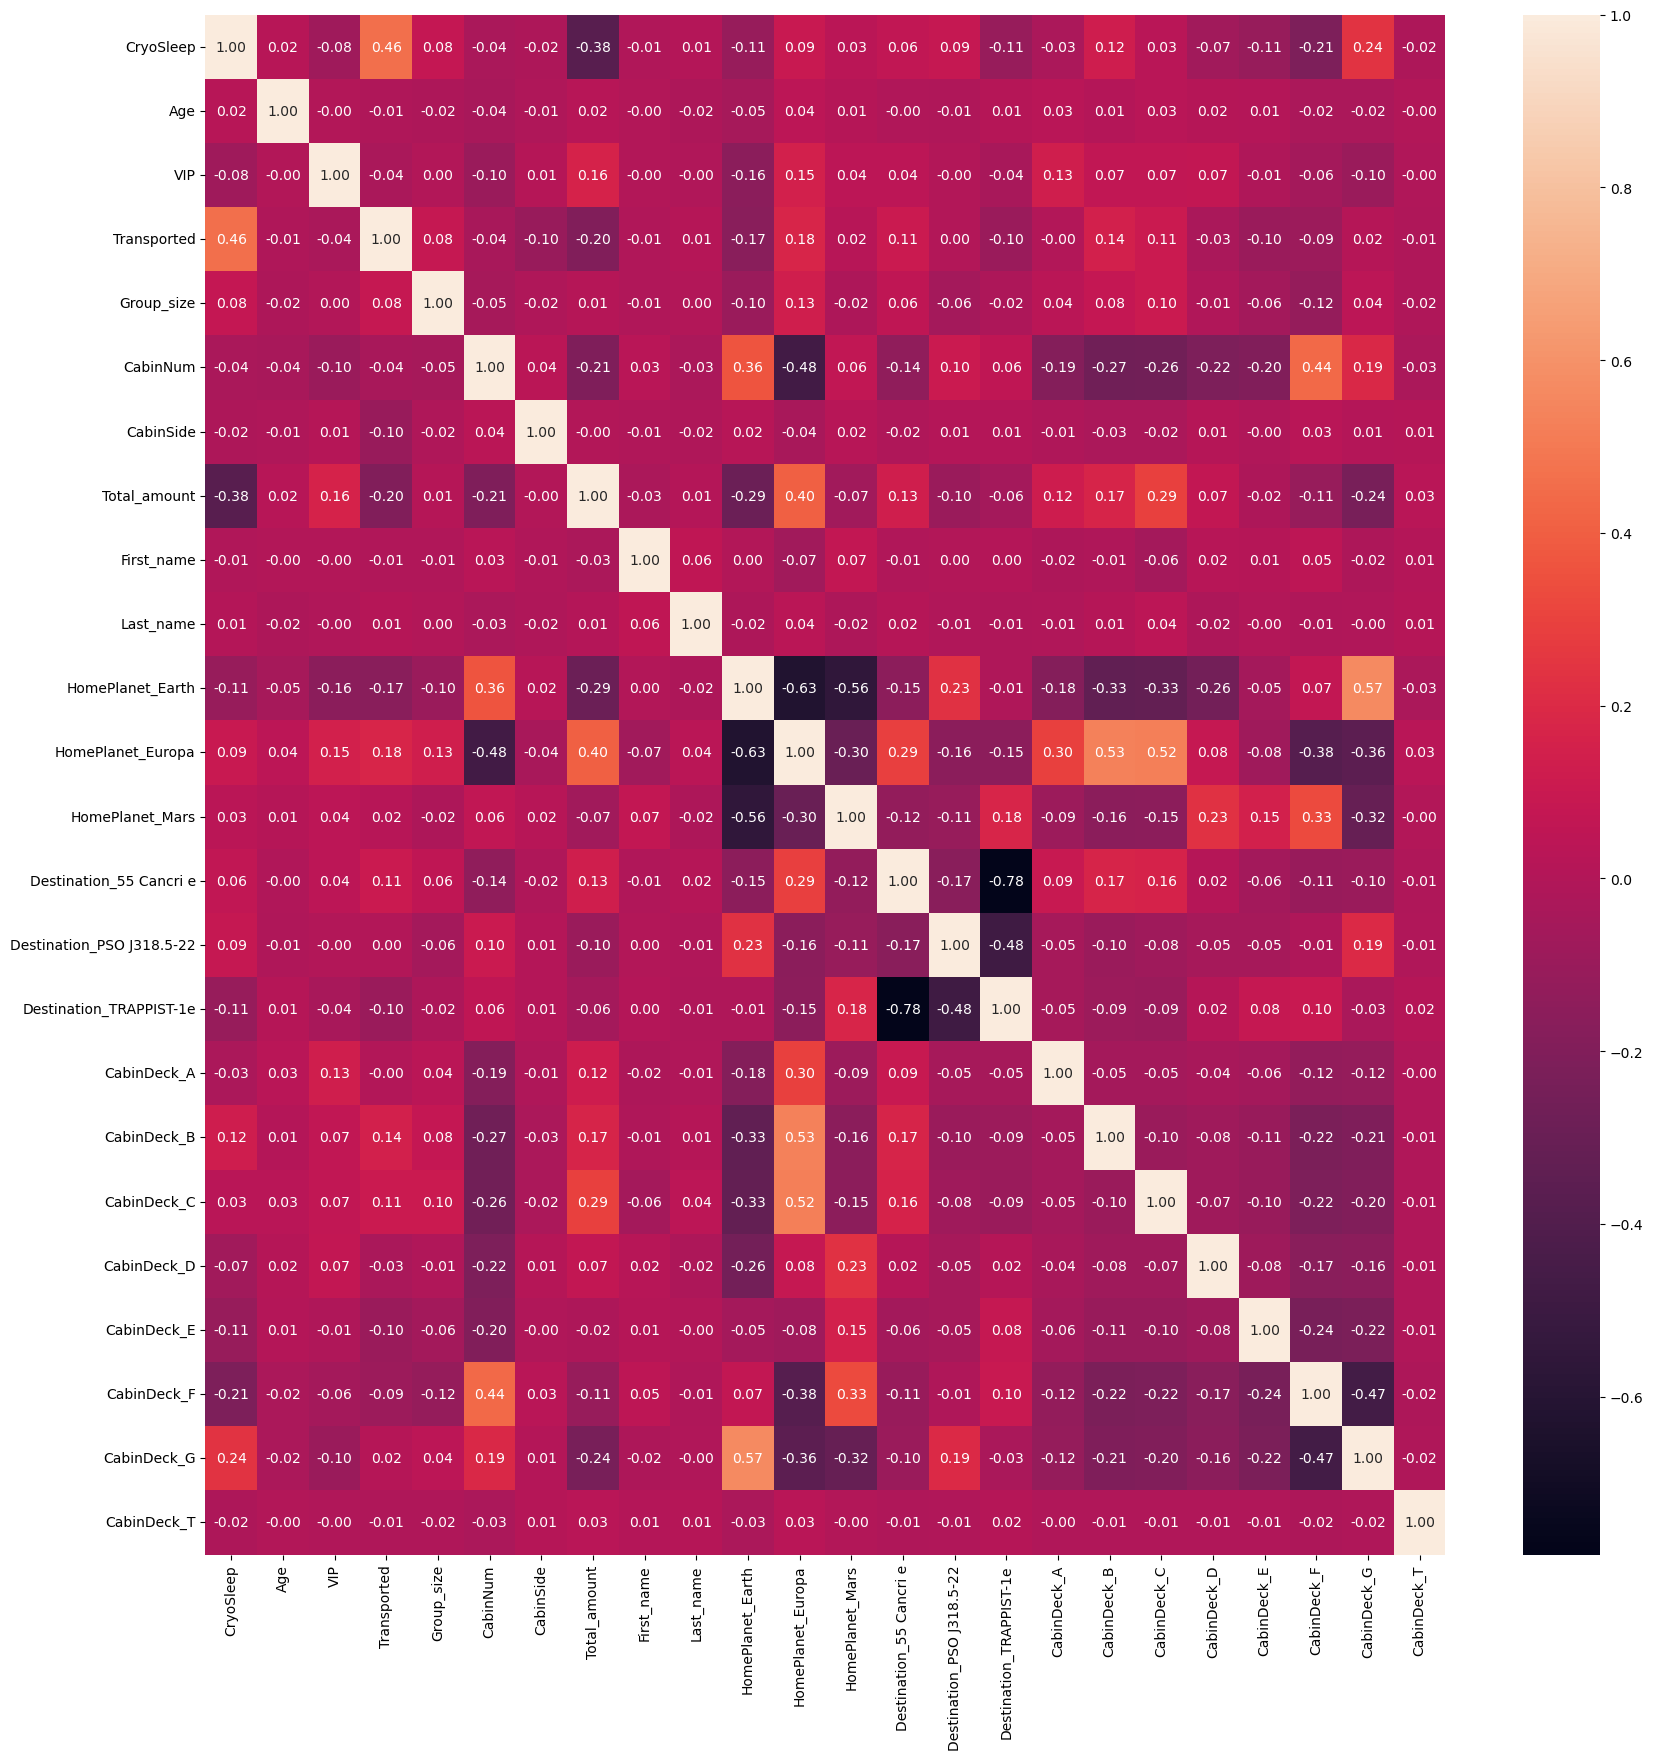

In [32]:
# correlation
f,ax = plt.subplots(figsize=(20, 20))
sns.heatmap(train_df.corr(), annot = True, fmt= '.2f')

we see that ```CryoSleep``` have a strong correlation with ```Transported``` status

# Split train, validation data
now we have to separate our data in train and validation set

In [33]:
from sklearn.model_selection import train_test_split
y = train_df["Transported"]
X = train_df.drop("Transported", axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.125, random_state=42)

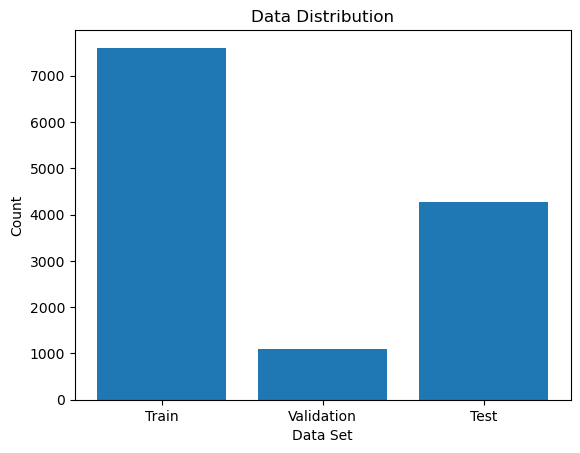

In [34]:
train_count = X_train.shape[0]
val_count = X_val.shape[0]
test_count = test_df.shape[0]

labels = ['Train', 'Validation', 'Test']
counts = [train_count, val_count, test_count]

plt.bar(labels, counts)

plt.title('Data Distribution')
plt.xlabel('Data Set')
plt.ylabel('Count')

# Display the chart
plt.show()

# Model

we are going to fit differents models and evaluate them to keep the best one
- KNeighborsClassifier
- RandomForestClassifier
- Neural Network (MLPClassifier)
- HistGradientBoostingClassifier
- CatBoostClassifier

In [35]:
# import models

from sklearn.model_selection import cross_val_score
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix

## KNeighborsClassifier

Classification Report:
               precision    recall  f1-score   support

         0.0       0.70      0.69      0.69       562
         1.0       0.67      0.68      0.67       525

    accuracy                           0.68      1087
   macro avg       0.68      0.68      0.68      1087
weighted avg       0.68      0.68      0.68      1087



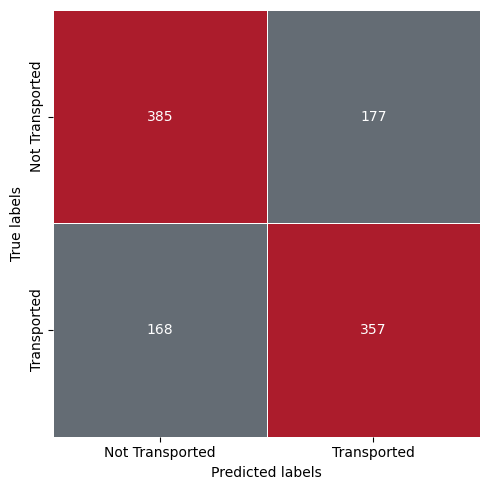

In [36]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_val)

# Create a classification report
report = classification_report(y_val, y_pred)
print("Classification Report:\n", report)

# accuracy
cv_knn = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy').mean()

# Create a confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Create a heatmap of the confusion matrix
fig, axs = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g', ax=axs, linewidths=0.5, cmap=custom_palette, cbar=False)
axs.set_xlabel('Predicted labels')
axs.set_ylabel('True labels'); 
axs.xaxis.set_ticklabels(['Not Transported', 'Transported'])
axs.yaxis.set_ticklabels(['Not Transported', 'Transported']);
plt.tight_layout()

## RandomForestClassifier

Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.81      0.76       562
         1.0       0.77      0.66      0.71       525

    accuracy                           0.74      1087
   macro avg       0.74      0.74      0.74      1087
weighted avg       0.74      0.74      0.74      1087



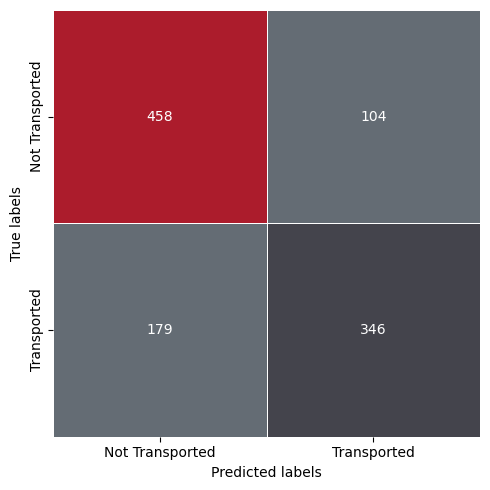

In [37]:
rff = RandomForestClassifier()
rff.fit(X_train, y_train)

y_pred = rff.predict(X_val)

# Create a classification report
report = classification_report(y_val, y_pred)
print("Classification Report:\n", report)

# accuracy
cv_rff = cross_val_score(rff, X_train, y_train, cv=5, scoring='accuracy').mean()

# Create a confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Create a heatmap of the confusion matrix
fig, axs = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g', ax=axs, linewidths=0.5, cmap=custom_palette, cbar=False)
axs.set_xlabel('Predicted labels')
axs.set_ylabel('True labels'); 
axs.xaxis.set_ticklabels(['Not Transported', 'Transported'])
axs.yaxis.set_ticklabels(['Not Transported', 'Transported']);
plt.tight_layout()

Classification Report:
               precision    recall  f1-score   support

         0.0       0.72      0.66      0.69       562
         1.0       0.67      0.73      0.70       525

    accuracy                           0.69      1087
   macro avg       0.69      0.69      0.69      1087
weighted avg       0.70      0.69      0.69      1087



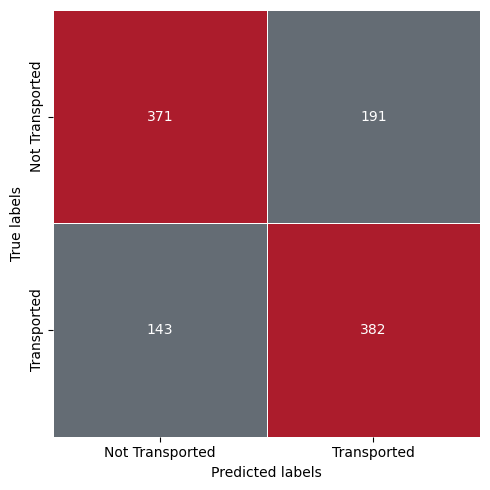

In [38]:
from sklearn.neural_network import MLPClassifier

network = MLPClassifier()
network.fit(X_train, y_train)

y_pred = network.predict(X_val)

# Create a classification report
report = classification_report(y_val, y_pred)
print("Classification Report:\n", report)

# Create a confusion matrix
cm = confusion_matrix(y_val, y_pred)

# accuracy
cv_network = cross_val_score(network, X_train, y_train, cv=5, scoring='accuracy').mean()

# Create a heatmap of the confusion matrix
fig, axs = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g', ax=axs, linewidths=0.5, cmap=custom_palette, cbar=False)
axs.set_xlabel('Predicted labels')
axs.set_ylabel('True labels'); 
axs.xaxis.set_ticklabels(['Not Transported', 'Transported'])
axs.yaxis.set_ticklabels(['Not Transported', 'Transported']);
plt.tight_layout()

## HistGradientBoostingClassifier

Classification Report:
               precision    recall  f1-score   support

         0.0       0.74      0.81      0.77       562
         1.0       0.77      0.69      0.73       525

    accuracy                           0.75      1087
   macro avg       0.75      0.75      0.75      1087
weighted avg       0.75      0.75      0.75      1087



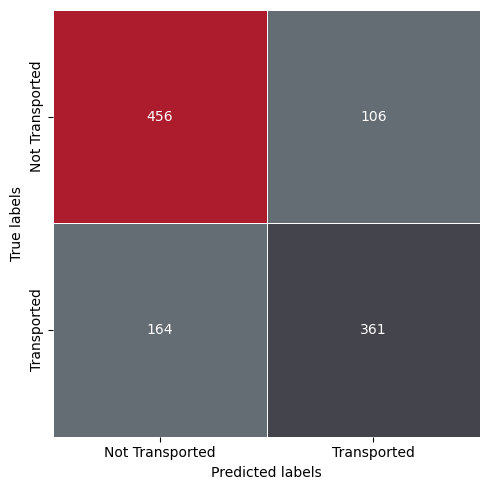

In [39]:
hg = HistGradientBoostingClassifier()

hg.fit(X_train, y_train)

y_pred = hg.predict(X_val)

# Create a classification report
report = classification_report(y_val, y_pred)
print("Classification Report:\n", report)

# Create a confusion matrix
cm = confusion_matrix(y_val, y_pred)

# accuracy
cv_hg = cross_val_score(hg, X_train, y_train, cv=5, scoring='accuracy').mean()

fig, axs = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g', ax=axs, linewidths=0.5, cmap=custom_palette, cbar=False)
axs.set_xlabel('Predicted labels')
axs.set_ylabel('True labels'); 
axs.xaxis.set_ticklabels(['Not Transported', 'Transported'])
axs.yaxis.set_ticklabels(['Not Transported', 'Transported']);
plt.tight_layout()

## CatBoostClassifier

Classification Report:
               precision    recall  f1-score   support

         0.0       0.74      0.81      0.78       562
         1.0       0.78      0.70      0.74       525

    accuracy                           0.76      1087
   macro avg       0.76      0.76      0.76      1087
weighted avg       0.76      0.76      0.76      1087



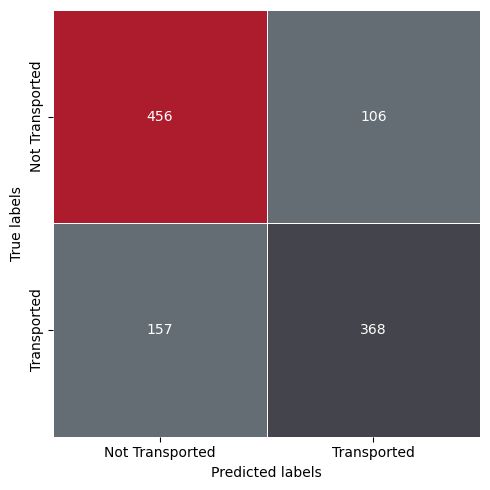

In [40]:
cat = CatBoostClassifier(verbose=False)

cat.fit(X_train, y_train)

y_pred = cat.predict(X_val)

# Create a classification report
report = classification_report(y_val, y_pred)
print("Classification Report:\n", report)

# Create a confusion matrix
cm = confusion_matrix(y_val, y_pred)

# accuracy
cv_cat = cross_val_score(cat, X_train, y_train, cv=5, scoring='accuracy').mean()

fig, axs = plt.subplots(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='g', ax=axs, linewidths=0.5, cmap=custom_palette, cbar=False)
axs.set_xlabel('Predicted labels')
axs.set_ylabel('True labels'); 
axs.xaxis.set_ticklabels(['Not Transported', 'Transported'])
axs.yaxis.set_ticklabels(['Not Transported', 'Transported']);
plt.tight_layout()

### Accuracy

In [41]:
print(f"KNN accuracy: {cv_knn}")
print(f"RFF accuracy: {cv_rff}")
print(f"Network accuracy: {cv_network}")
print(f"HG accuracy: {cv_hg}")
print(f"CatBoost accuracy: {cv_cat}")

KNN accuracy: 0.6773594555763767
RFF accuracy: 0.7475684698064158
Network accuracy: 0.6488389010273171
HG accuracy: 0.7480942667741414
CatBoost accuracy: 0.7557198779072831


In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Assuming you have your features X_train, X_val, y_train, y_val

# Initialize CatBoost Classifier
model = CatBoostClassifier()

# Define the parameter grid for grid search
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 1],
    'iterations': [100, 200, 300]
}

# Perform grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_
print("Best Parameters:", best_params)
print("Best Score:", best_score)

# Use the best model for predictions
best_model = grid_search.best_estimator_
y_pred_val = best_model.predict(X_val)
accuracy_val = accuracy_score(y_val, y_pred_val)
print("Validation Accuracy:", accuracy_val)

# Make predictions on the test data
y_pred_test = best_model.predict(X_test)

# Calculate the accuracy score for the test data
accuracy_test = accuracy_score(y_test, y_pred_test)
print("Test Accuracy:", accuracy_test)

0:	learn: 0.6895775	total: 2.56ms	remaining: 253ms
1:	learn: 0.6858096	total: 5.08ms	remaining: 249ms
2:	learn: 0.6814716	total: 7.34ms	remaining: 237ms
3:	learn: 0.6781785	total: 9.52ms	remaining: 228ms
4:	learn: 0.6747207	total: 11.7ms	remaining: 222ms
5:	learn: 0.6708795	total: 13.8ms	remaining: 217ms
6:	learn: 0.6674436	total: 16.1ms	remaining: 213ms
7:	learn: 0.6642565	total: 18.5ms	remaining: 213ms
8:	learn: 0.6613699	total: 20.8ms	remaining: 210ms
9:	learn: 0.6585254	total: 23ms	remaining: 207ms
10:	learn: 0.6556506	total: 25.2ms	remaining: 204ms
11:	learn: 0.6531411	total: 27.5ms	remaining: 202ms
12:	learn: 0.6500264	total: 29.9ms	remaining: 200ms
13:	learn: 0.6472149	total: 32.4ms	remaining: 199ms
14:	learn: 0.6444128	total: 34.8ms	remaining: 197ms
15:	learn: 0.6415487	total: 37.2ms	remaining: 195ms
16:	learn: 0.6396505	total: 39.4ms	remaining: 192ms
17:	learn: 0.6368399	total: 41.8ms	remaining: 191ms
18:	learn: 0.6345825	total: 44.2ms	remaining: 189ms
19:	learn: 0.6318136	tot

99:	learn: 0.5410129	total: 260ms	remaining: 0us
0:	learn: 0.6894438	total: 2.62ms	remaining: 259ms
1:	learn: 0.6856539	total: 4.98ms	remaining: 244ms
2:	learn: 0.6815480	total: 7.37ms	remaining: 238ms
3:	learn: 0.6779561	total: 9.7ms	remaining: 233ms
4:	learn: 0.6745899	total: 12.3ms	remaining: 234ms
5:	learn: 0.6713840	total: 14.9ms	remaining: 234ms
6:	learn: 0.6679352	total: 17.4ms	remaining: 231ms
7:	learn: 0.6643308	total: 19.9ms	remaining: 229ms
8:	learn: 0.6612075	total: 22.3ms	remaining: 226ms
9:	learn: 0.6581843	total: 24.7ms	remaining: 223ms
10:	learn: 0.6556565	total: 26.9ms	remaining: 217ms
11:	learn: 0.6524023	total: 29.7ms	remaining: 218ms
12:	learn: 0.6496860	total: 32.4ms	remaining: 217ms
13:	learn: 0.6473181	total: 35ms	remaining: 215ms
14:	learn: 0.6448620	total: 37.6ms	remaining: 213ms
15:	learn: 0.6418337	total: 40ms	remaining: 210ms
16:	learn: 0.6391936	total: 42.6ms	remaining: 208ms
17:	learn: 0.6365977	total: 45.1ms	remaining: 206ms
18:	learn: 0.6340321	total: 47

0:	learn: 0.6582288	total: 2.63ms	remaining: 261ms
1:	learn: 0.6284996	total: 5.17ms	remaining: 253ms
2:	learn: 0.6068465	total: 7.66ms	remaining: 248ms
3:	learn: 0.5881951	total: 10.6ms	remaining: 254ms
4:	learn: 0.5780324	total: 13.6ms	remaining: 258ms
5:	learn: 0.5670997	total: 16.5ms	remaining: 259ms
6:	learn: 0.5592769	total: 19.2ms	remaining: 255ms
7:	learn: 0.5509559	total: 21.7ms	remaining: 250ms
8:	learn: 0.5462141	total: 24.1ms	remaining: 244ms
9:	learn: 0.5392368	total: 26.7ms	remaining: 240ms
10:	learn: 0.5338301	total: 29.3ms	remaining: 237ms
11:	learn: 0.5296181	total: 31.9ms	remaining: 234ms
12:	learn: 0.5257006	total: 34ms	remaining: 227ms
13:	learn: 0.5229174	total: 36.2ms	remaining: 223ms
14:	learn: 0.5203746	total: 38.6ms	remaining: 219ms
15:	learn: 0.5182137	total: 41ms	remaining: 215ms
16:	learn: 0.5172996	total: 43.5ms	remaining: 212ms
17:	learn: 0.5154290	total: 45.9ms	remaining: 209ms
18:	learn: 0.5135111	total: 48.4ms	remaining: 207ms
19:	learn: 0.5096781	total

78:	learn: 0.4770589	total: 204ms	remaining: 54.3ms
79:	learn: 0.4767789	total: 207ms	remaining: 51.7ms
80:	learn: 0.4763856	total: 209ms	remaining: 49.1ms
81:	learn: 0.4759767	total: 212ms	remaining: 46.5ms
82:	learn: 0.4757398	total: 214ms	remaining: 43.9ms
83:	learn: 0.4753267	total: 217ms	remaining: 41.3ms
84:	learn: 0.4749779	total: 220ms	remaining: 38.7ms
85:	learn: 0.4746213	total: 222ms	remaining: 36.1ms
86:	learn: 0.4742334	total: 224ms	remaining: 33.5ms
87:	learn: 0.4736758	total: 227ms	remaining: 30.9ms
88:	learn: 0.4733168	total: 229ms	remaining: 28.3ms
89:	learn: 0.4729977	total: 232ms	remaining: 25.7ms
90:	learn: 0.4725420	total: 234ms	remaining: 23.2ms
91:	learn: 0.4721527	total: 237ms	remaining: 20.6ms
92:	learn: 0.4716430	total: 239ms	remaining: 18ms
93:	learn: 0.4709947	total: 241ms	remaining: 15.4ms
94:	learn: 0.4706045	total: 244ms	remaining: 12.8ms
95:	learn: 0.4700742	total: 246ms	remaining: 10.3ms
96:	learn: 0.4692730	total: 248ms	remaining: 7.68ms
97:	learn: 0.4

56:	learn: 0.3588054	total: 141ms	remaining: 106ms
57:	learn: 0.3564106	total: 144ms	remaining: 104ms
58:	learn: 0.3544958	total: 146ms	remaining: 102ms
59:	learn: 0.3533719	total: 149ms	remaining: 99.3ms
60:	learn: 0.3515720	total: 151ms	remaining: 96.8ms
61:	learn: 0.3497760	total: 154ms	remaining: 94.4ms
62:	learn: 0.3485290	total: 157ms	remaining: 92ms
63:	learn: 0.3465136	total: 159ms	remaining: 89.4ms
64:	learn: 0.3447454	total: 161ms	remaining: 86.9ms
65:	learn: 0.3431087	total: 164ms	remaining: 84.5ms
66:	learn: 0.3413418	total: 166ms	remaining: 81.9ms
67:	learn: 0.3379097	total: 169ms	remaining: 79.5ms
68:	learn: 0.3355188	total: 171ms	remaining: 77ms
69:	learn: 0.3335666	total: 174ms	remaining: 74.5ms
70:	learn: 0.3319275	total: 176ms	remaining: 72ms
71:	learn: 0.3303853	total: 179ms	remaining: 69.5ms
72:	learn: 0.3290794	total: 181ms	remaining: 67ms
73:	learn: 0.3272083	total: 184ms	remaining: 64.5ms
74:	learn: 0.3257596	total: 186ms	remaining: 62ms
75:	learn: 0.3241834	tota

64:	learn: 0.5650439	total: 162ms	remaining: 337ms
65:	learn: 0.5644121	total: 164ms	remaining: 334ms
66:	learn: 0.5636910	total: 167ms	remaining: 332ms
67:	learn: 0.5627261	total: 170ms	remaining: 329ms
68:	learn: 0.5613728	total: 172ms	remaining: 327ms
69:	learn: 0.5606439	total: 175ms	remaining: 324ms
70:	learn: 0.5593838	total: 177ms	remaining: 322ms
71:	learn: 0.5588140	total: 180ms	remaining: 319ms
72:	learn: 0.5578960	total: 182ms	remaining: 317ms
73:	learn: 0.5572702	total: 184ms	remaining: 314ms
74:	learn: 0.5563456	total: 187ms	remaining: 311ms
75:	learn: 0.5556625	total: 189ms	remaining: 309ms
76:	learn: 0.5547605	total: 192ms	remaining: 306ms
77:	learn: 0.5539505	total: 194ms	remaining: 304ms
78:	learn: 0.5533997	total: 197ms	remaining: 301ms
79:	learn: 0.5523061	total: 199ms	remaining: 298ms
80:	learn: 0.5518447	total: 201ms	remaining: 295ms
81:	learn: 0.5513382	total: 204ms	remaining: 293ms
82:	learn: 0.5504387	total: 206ms	remaining: 290ms
83:	learn: 0.5500199	total: 208

40:	learn: 0.5904863	total: 102ms	remaining: 396ms
41:	learn: 0.5886349	total: 105ms	remaining: 394ms
42:	learn: 0.5869280	total: 107ms	remaining: 392ms
43:	learn: 0.5859518	total: 110ms	remaining: 389ms
44:	learn: 0.5844206	total: 112ms	remaining: 387ms
45:	learn: 0.5833298	total: 115ms	remaining: 385ms
46:	learn: 0.5822825	total: 118ms	remaining: 383ms
47:	learn: 0.5804986	total: 120ms	remaining: 380ms
48:	learn: 0.5792526	total: 123ms	remaining: 378ms
49:	learn: 0.5778484	total: 125ms	remaining: 375ms
50:	learn: 0.5771156	total: 127ms	remaining: 372ms
51:	learn: 0.5760136	total: 130ms	remaining: 370ms
52:	learn: 0.5753420	total: 132ms	remaining: 367ms
53:	learn: 0.5740834	total: 136ms	remaining: 366ms
54:	learn: 0.5728107	total: 138ms	remaining: 364ms
55:	learn: 0.5714382	total: 141ms	remaining: 362ms
56:	learn: 0.5701482	total: 143ms	remaining: 359ms
57:	learn: 0.5691921	total: 146ms	remaining: 356ms
58:	learn: 0.5681142	total: 148ms	remaining: 354ms
59:	learn: 0.5669530	total: 151

0:	learn: 0.6894438	total: 2.57ms	remaining: 511ms
1:	learn: 0.6856539	total: 5.21ms	remaining: 516ms
2:	learn: 0.6815480	total: 7.73ms	remaining: 508ms
3:	learn: 0.6779561	total: 10.1ms	remaining: 495ms
4:	learn: 0.6745899	total: 12.6ms	remaining: 490ms
5:	learn: 0.6713840	total: 15.1ms	remaining: 488ms
6:	learn: 0.6679352	total: 17.5ms	remaining: 483ms
7:	learn: 0.6643308	total: 20ms	remaining: 481ms
8:	learn: 0.6612075	total: 22.4ms	remaining: 476ms
9:	learn: 0.6581843	total: 24.9ms	remaining: 473ms
10:	learn: 0.6556565	total: 27.1ms	remaining: 465ms
11:	learn: 0.6524023	total: 29.3ms	remaining: 460ms
12:	learn: 0.6496860	total: 31.8ms	remaining: 457ms
13:	learn: 0.6473181	total: 34.2ms	remaining: 455ms
14:	learn: 0.6448620	total: 36.6ms	remaining: 451ms
15:	learn: 0.6418337	total: 38.9ms	remaining: 448ms
16:	learn: 0.6391936	total: 41.3ms	remaining: 445ms
17:	learn: 0.6365977	total: 43.7ms	remaining: 442ms
18:	learn: 0.6340321	total: 46.1ms	remaining: 439ms
19:	learn: 0.6315602	tot

181:	learn: 0.5199576	total: 453ms	remaining: 44.8ms
182:	learn: 0.5196379	total: 457ms	remaining: 42.4ms
183:	learn: 0.5194646	total: 459ms	remaining: 40ms
184:	learn: 0.5192097	total: 462ms	remaining: 37.5ms
185:	learn: 0.5191169	total: 465ms	remaining: 35ms
186:	learn: 0.5188953	total: 468ms	remaining: 32.5ms
187:	learn: 0.5187136	total: 471ms	remaining: 30.1ms
188:	learn: 0.5186073	total: 474ms	remaining: 27.6ms
189:	learn: 0.5184762	total: 476ms	remaining: 25.1ms
190:	learn: 0.5182879	total: 479ms	remaining: 22.6ms
191:	learn: 0.5180016	total: 482ms	remaining: 20.1ms
192:	learn: 0.5178976	total: 484ms	remaining: 17.6ms
193:	learn: 0.5176992	total: 487ms	remaining: 15.1ms
194:	learn: 0.5174887	total: 490ms	remaining: 12.6ms
195:	learn: 0.5173651	total: 492ms	remaining: 10.1ms
196:	learn: 0.5172616	total: 495ms	remaining: 7.54ms
197:	learn: 0.5170789	total: 498ms	remaining: 5.03ms
198:	learn: 0.5167038	total: 501ms	remaining: 2.52ms
199:	learn: 0.5165417	total: 504ms	remaining: 0us


176:	learn: 0.4265640	total: 458ms	remaining: 59.5ms
177:	learn: 0.4262260	total: 461ms	remaining: 56.9ms
178:	learn: 0.4259501	total: 463ms	remaining: 54.3ms
179:	learn: 0.4255988	total: 466ms	remaining: 51.7ms
180:	learn: 0.4252064	total: 468ms	remaining: 49.1ms
181:	learn: 0.4247347	total: 471ms	remaining: 46.5ms
182:	learn: 0.4243489	total: 473ms	remaining: 44ms
183:	learn: 0.4240507	total: 476ms	remaining: 41.4ms
184:	learn: 0.4236356	total: 478ms	remaining: 38.8ms
185:	learn: 0.4232787	total: 481ms	remaining: 36.2ms
186:	learn: 0.4228661	total: 484ms	remaining: 33.6ms
187:	learn: 0.4224353	total: 486ms	remaining: 31ms
188:	learn: 0.4221474	total: 489ms	remaining: 28.4ms
189:	learn: 0.4217481	total: 491ms	remaining: 25.9ms
190:	learn: 0.4214014	total: 494ms	remaining: 23.3ms
191:	learn: 0.4209731	total: 496ms	remaining: 20.7ms
192:	learn: 0.4205529	total: 499ms	remaining: 18.1ms
193:	learn: 0.4201236	total: 501ms	remaining: 15.5ms
194:	learn: 0.4197071	total: 504ms	remaining: 12.9

160:	learn: 0.4351276	total: 414ms	remaining: 100ms
161:	learn: 0.4347755	total: 416ms	remaining: 97.7ms
162:	learn: 0.4343996	total: 419ms	remaining: 95.1ms
163:	learn: 0.4341913	total: 422ms	remaining: 92.5ms
164:	learn: 0.4338128	total: 424ms	remaining: 90ms
165:	learn: 0.4330533	total: 427ms	remaining: 87.4ms
166:	learn: 0.4326883	total: 429ms	remaining: 84.8ms
167:	learn: 0.4323578	total: 432ms	remaining: 82.2ms
168:	learn: 0.4320888	total: 434ms	remaining: 79.6ms
169:	learn: 0.4317626	total: 437ms	remaining: 77.1ms
170:	learn: 0.4315222	total: 439ms	remaining: 74.5ms
171:	learn: 0.4311633	total: 442ms	remaining: 72ms
172:	learn: 0.4309035	total: 445ms	remaining: 69.4ms
173:	learn: 0.4304683	total: 447ms	remaining: 66.8ms
174:	learn: 0.4299621	total: 449ms	remaining: 64.2ms
175:	learn: 0.4297434	total: 452ms	remaining: 61.6ms
176:	learn: 0.4294839	total: 454ms	remaining: 59ms
177:	learn: 0.4291638	total: 457ms	remaining: 56.5ms
178:	learn: 0.4281481	total: 460ms	remaining: 54ms
17

178:	learn: 0.4331478	total: 453ms	remaining: 53.2ms
179:	learn: 0.4328911	total: 456ms	remaining: 50.7ms
180:	learn: 0.4324977	total: 459ms	remaining: 48.1ms
181:	learn: 0.4322367	total: 461ms	remaining: 45.6ms
182:	learn: 0.4320582	total: 464ms	remaining: 43.1ms
183:	learn: 0.4317300	total: 466ms	remaining: 40.5ms
184:	learn: 0.4314280	total: 469ms	remaining: 38ms
185:	learn: 0.4311463	total: 472ms	remaining: 35.5ms
186:	learn: 0.4308724	total: 475ms	remaining: 33ms
187:	learn: 0.4306252	total: 478ms	remaining: 30.5ms
188:	learn: 0.4304060	total: 480ms	remaining: 27.9ms
189:	learn: 0.4300100	total: 483ms	remaining: 25.4ms
190:	learn: 0.4297134	total: 485ms	remaining: 22.9ms
191:	learn: 0.4293343	total: 488ms	remaining: 20.3ms
192:	learn: 0.4289530	total: 491ms	remaining: 17.8ms
193:	learn: 0.4287481	total: 494ms	remaining: 15.3ms
194:	learn: 0.4283262	total: 496ms	remaining: 12.7ms
195:	learn: 0.4279660	total: 499ms	remaining: 10.2ms
196:	learn: 0.4275669	total: 501ms	remaining: 7.63

142:	learn: 0.2181594	total: 350ms	remaining: 140ms
143:	learn: 0.2170585	total: 353ms	remaining: 137ms
144:	learn: 0.2156896	total: 355ms	remaining: 135ms
145:	learn: 0.2150282	total: 358ms	remaining: 132ms
146:	learn: 0.2140413	total: 360ms	remaining: 130ms
147:	learn: 0.2129799	total: 363ms	remaining: 128ms
148:	learn: 0.2122895	total: 366ms	remaining: 125ms
149:	learn: 0.2110072	total: 369ms	remaining: 123ms
150:	learn: 0.2098087	total: 372ms	remaining: 121ms
151:	learn: 0.2085621	total: 374ms	remaining: 118ms
152:	learn: 0.2078923	total: 377ms	remaining: 116ms
153:	learn: 0.2066048	total: 379ms	remaining: 113ms
154:	learn: 0.2056177	total: 382ms	remaining: 111ms
155:	learn: 0.2045184	total: 385ms	remaining: 109ms
156:	learn: 0.2030744	total: 388ms	remaining: 106ms
157:	learn: 0.2017741	total: 390ms	remaining: 104ms
158:	learn: 0.2004389	total: 393ms	remaining: 101ms
159:	learn: 0.1994126	total: 395ms	remaining: 98.8ms
160:	learn: 0.1987699	total: 399ms	remaining: 96.6ms
161:	learn

158:	learn: 0.2194608	total: 402ms	remaining: 104ms
159:	learn: 0.2189818	total: 404ms	remaining: 101ms
160:	learn: 0.2178582	total: 407ms	remaining: 98.5ms
161:	learn: 0.2172177	total: 409ms	remaining: 96ms
162:	learn: 0.2161775	total: 412ms	remaining: 93.4ms
163:	learn: 0.2152746	total: 414ms	remaining: 90.9ms
164:	learn: 0.2143576	total: 417ms	remaining: 88.4ms
165:	learn: 0.2132664	total: 419ms	remaining: 85.9ms
166:	learn: 0.2120593	total: 422ms	remaining: 83.5ms
167:	learn: 0.2116602	total: 425ms	remaining: 81ms
168:	learn: 0.2104451	total: 428ms	remaining: 78.5ms
169:	learn: 0.2094109	total: 430ms	remaining: 75.9ms
170:	learn: 0.2082975	total: 433ms	remaining: 73.4ms
171:	learn: 0.2071714	total: 435ms	remaining: 70.9ms
172:	learn: 0.2066493	total: 438ms	remaining: 68.4ms
173:	learn: 0.2055399	total: 441ms	remaining: 65.9ms
174:	learn: 0.2042714	total: 444ms	remaining: 63.4ms
175:	learn: 0.2034107	total: 447ms	remaining: 61ms
176:	learn: 0.2020593	total: 449ms	remaining: 58.4ms
1

184:	learn: 0.1863890	total: 453ms	remaining: 36.7ms
185:	learn: 0.1853973	total: 456ms	remaining: 34.3ms
186:	learn: 0.1848615	total: 458ms	remaining: 31.8ms
187:	learn: 0.1835452	total: 461ms	remaining: 29.4ms
188:	learn: 0.1824740	total: 463ms	remaining: 26.9ms
189:	learn: 0.1814776	total: 466ms	remaining: 24.5ms
190:	learn: 0.1805966	total: 469ms	remaining: 22.1ms
191:	learn: 0.1796840	total: 471ms	remaining: 19.6ms
192:	learn: 0.1782989	total: 474ms	remaining: 17.2ms
193:	learn: 0.1775840	total: 476ms	remaining: 14.7ms
194:	learn: 0.1772513	total: 478ms	remaining: 12.3ms
195:	learn: 0.1766358	total: 483ms	remaining: 9.85ms
196:	learn: 0.1758753	total: 487ms	remaining: 7.41ms
197:	learn: 0.1748739	total: 494ms	remaining: 4.99ms
198:	learn: 0.1744591	total: 499ms	remaining: 2.5ms
199:	learn: 0.1735250	total: 501ms	remaining: 0us
0:	learn: 0.6895775	total: 2.63ms	remaining: 785ms
1:	learn: 0.6858096	total: 5.04ms	remaining: 751ms
2:	learn: 0.6814716	total: 7.41ms	remaining: 733ms
3:	

207:	learn: 0.5097518	total: 510ms	remaining: 226ms
208:	learn: 0.5096094	total: 513ms	remaining: 223ms
209:	learn: 0.5094285	total: 515ms	remaining: 221ms
210:	learn: 0.5092212	total: 517ms	remaining: 218ms
211:	learn: 0.5089902	total: 520ms	remaining: 216ms
212:	learn: 0.5088759	total: 522ms	remaining: 213ms
213:	learn: 0.5087544	total: 525ms	remaining: 211ms
214:	learn: 0.5085576	total: 527ms	remaining: 208ms
215:	learn: 0.5082749	total: 530ms	remaining: 206ms
216:	learn: 0.5081084	total: 532ms	remaining: 203ms
217:	learn: 0.5079503	total: 534ms	remaining: 201ms
218:	learn: 0.5078468	total: 537ms	remaining: 199ms
219:	learn: 0.5076221	total: 539ms	remaining: 196ms
220:	learn: 0.5074958	total: 541ms	remaining: 194ms
221:	learn: 0.5072497	total: 544ms	remaining: 191ms
222:	learn: 0.5071394	total: 547ms	remaining: 189ms
223:	learn: 0.5070421	total: 549ms	remaining: 186ms
224:	learn: 0.5069688	total: 551ms	remaining: 184ms
225:	learn: 0.5068625	total: 555ms	remaining: 182ms
226:	learn: 

122:	learn: 0.5311597	total: 332ms	remaining: 478ms
123:	learn: 0.5309670	total: 335ms	remaining: 475ms
124:	learn: 0.5304327	total: 337ms	remaining: 472ms
125:	learn: 0.5300014	total: 340ms	remaining: 469ms
126:	learn: 0.5296105	total: 342ms	remaining: 466ms
127:	learn: 0.5291602	total: 345ms	remaining: 464ms
128:	learn: 0.5288205	total: 351ms	remaining: 466ms
129:	learn: 0.5282127	total: 354ms	remaining: 463ms
130:	learn: 0.5279000	total: 357ms	remaining: 460ms
131:	learn: 0.5276335	total: 359ms	remaining: 457ms
132:	learn: 0.5273210	total: 362ms	remaining: 454ms
133:	learn: 0.5269558	total: 364ms	remaining: 451ms
134:	learn: 0.5266815	total: 367ms	remaining: 448ms
135:	learn: 0.5265096	total: 369ms	remaining: 445ms
136:	learn: 0.5262616	total: 371ms	remaining: 442ms
137:	learn: 0.5260611	total: 374ms	remaining: 439ms
138:	learn: 0.5258019	total: 377ms	remaining: 437ms
139:	learn: 0.5255050	total: 379ms	remaining: 433ms
140:	learn: 0.5251548	total: 382ms	remaining: 430ms
141:	learn: 

44:	learn: 0.5889335	total: 111ms	remaining: 628ms
45:	learn: 0.5875801	total: 114ms	remaining: 628ms
46:	learn: 0.5866185	total: 116ms	remaining: 627ms
47:	learn: 0.5851001	total: 119ms	remaining: 625ms
48:	learn: 0.5840756	total: 121ms	remaining: 622ms
49:	learn: 0.5828767	total: 124ms	remaining: 620ms
50:	learn: 0.5820881	total: 127ms	remaining: 620ms
51:	learn: 0.5813528	total: 130ms	remaining: 618ms
52:	learn: 0.5803052	total: 132ms	remaining: 617ms
53:	learn: 0.5791039	total: 135ms	remaining: 615ms
54:	learn: 0.5778689	total: 137ms	remaining: 612ms
55:	learn: 0.5769904	total: 141ms	remaining: 613ms
56:	learn: 0.5757257	total: 144ms	remaining: 612ms
57:	learn: 0.5748635	total: 146ms	remaining: 611ms
58:	learn: 0.5741567	total: 149ms	remaining: 609ms
59:	learn: 0.5731932	total: 152ms	remaining: 606ms
60:	learn: 0.5724087	total: 154ms	remaining: 604ms
61:	learn: 0.5718423	total: 157ms	remaining: 601ms
62:	learn: 0.5711958	total: 159ms	remaining: 598ms
63:	learn: 0.5704455	total: 161

279:	learn: 0.5055146	total: 709ms	remaining: 50.7ms
280:	learn: 0.5053956	total: 712ms	remaining: 48.2ms
281:	learn: 0.5053388	total: 715ms	remaining: 45.6ms
282:	learn: 0.5051894	total: 717ms	remaining: 43.1ms
283:	learn: 0.5051387	total: 720ms	remaining: 40.6ms
284:	learn: 0.5050130	total: 723ms	remaining: 38.1ms
285:	learn: 0.5049500	total: 726ms	remaining: 35.6ms
286:	learn: 0.5048966	total: 729ms	remaining: 33ms
287:	learn: 0.5048320	total: 732ms	remaining: 30.5ms
288:	learn: 0.5047463	total: 734ms	remaining: 28ms
289:	learn: 0.5046156	total: 737ms	remaining: 25.4ms
290:	learn: 0.5044594	total: 740ms	remaining: 22.9ms
291:	learn: 0.5043823	total: 742ms	remaining: 20.3ms
292:	learn: 0.5043360	total: 744ms	remaining: 17.8ms
293:	learn: 0.5042527	total: 747ms	remaining: 15.2ms
294:	learn: 0.5041435	total: 749ms	remaining: 12.7ms
295:	learn: 0.5040969	total: 752ms	remaining: 10.2ms
296:	learn: 0.5040023	total: 754ms	remaining: 7.62ms
297:	learn: 0.5038948	total: 756ms	remaining: 5.08

210:	learn: 0.4143015	total: 517ms	remaining: 218ms
211:	learn: 0.4138937	total: 520ms	remaining: 216ms
212:	learn: 0.4135302	total: 522ms	remaining: 213ms
213:	learn: 0.4133363	total: 525ms	remaining: 211ms
214:	learn: 0.4129959	total: 527ms	remaining: 208ms
215:	learn: 0.4126989	total: 530ms	remaining: 206ms
216:	learn: 0.4122729	total: 534ms	remaining: 204ms
217:	learn: 0.4119141	total: 538ms	remaining: 202ms
218:	learn: 0.4116389	total: 542ms	remaining: 200ms
219:	learn: 0.4112847	total: 549ms	remaining: 200ms
220:	learn: 0.4109127	total: 552ms	remaining: 197ms
221:	learn: 0.4106259	total: 554ms	remaining: 195ms
222:	learn: 0.4102745	total: 557ms	remaining: 192ms
223:	learn: 0.4100396	total: 559ms	remaining: 190ms
224:	learn: 0.4095467	total: 562ms	remaining: 187ms
225:	learn: 0.4092394	total: 564ms	remaining: 185ms
226:	learn: 0.4090448	total: 566ms	remaining: 182ms
227:	learn: 0.4088947	total: 569ms	remaining: 180ms
228:	learn: 0.4086191	total: 571ms	remaining: 177ms
229:	learn: 

131:	learn: 0.4459839	total: 334ms	remaining: 425ms
132:	learn: 0.4456256	total: 337ms	remaining: 423ms
133:	learn: 0.4452351	total: 339ms	remaining: 420ms
134:	learn: 0.4447855	total: 342ms	remaining: 418ms
135:	learn: 0.4443616	total: 344ms	remaining: 415ms
136:	learn: 0.4440449	total: 347ms	remaining: 413ms
137:	learn: 0.4438433	total: 350ms	remaining: 411ms
138:	learn: 0.4434179	total: 352ms	remaining: 408ms
139:	learn: 0.4430655	total: 355ms	remaining: 405ms
140:	learn: 0.4426344	total: 357ms	remaining: 403ms
141:	learn: 0.4421892	total: 360ms	remaining: 400ms
142:	learn: 0.4419041	total: 362ms	remaining: 397ms
143:	learn: 0.4416545	total: 364ms	remaining: 395ms
144:	learn: 0.4413572	total: 367ms	remaining: 392ms
145:	learn: 0.4409700	total: 369ms	remaining: 390ms
146:	learn: 0.4404157	total: 372ms	remaining: 387ms
147:	learn: 0.4399899	total: 374ms	remaining: 384ms
148:	learn: 0.4397083	total: 377ms	remaining: 382ms
149:	learn: 0.4394789	total: 379ms	remaining: 379ms
150:	learn: 

52:	learn: 0.4881945	total: 130ms	remaining: 606ms
53:	learn: 0.4875567	total: 133ms	remaining: 605ms
54:	learn: 0.4867931	total: 135ms	remaining: 603ms
55:	learn: 0.4865255	total: 138ms	remaining: 601ms
56:	learn: 0.4859889	total: 140ms	remaining: 599ms
57:	learn: 0.4855072	total: 143ms	remaining: 597ms
58:	learn: 0.4847037	total: 146ms	remaining: 595ms
59:	learn: 0.4844681	total: 148ms	remaining: 593ms
60:	learn: 0.4840138	total: 151ms	remaining: 591ms
61:	learn: 0.4836051	total: 153ms	remaining: 588ms
62:	learn: 0.4830162	total: 156ms	remaining: 586ms
63:	learn: 0.4824384	total: 158ms	remaining: 583ms
64:	learn: 0.4820887	total: 161ms	remaining: 580ms
65:	learn: 0.4817081	total: 163ms	remaining: 578ms
66:	learn: 0.4814048	total: 166ms	remaining: 576ms
67:	learn: 0.4810828	total: 168ms	remaining: 573ms
68:	learn: 0.4808279	total: 171ms	remaining: 571ms
69:	learn: 0.4804572	total: 173ms	remaining: 569ms
70:	learn: 0.4802802	total: 176ms	remaining: 567ms
71:	learn: 0.4797913	total: 178

280:	learn: 0.4028878	total: 706ms	remaining: 47.8ms
281:	learn: 0.4024424	total: 710ms	remaining: 45.3ms
282:	learn: 0.4019337	total: 712ms	remaining: 42.8ms
283:	learn: 0.4016942	total: 715ms	remaining: 40.3ms
284:	learn: 0.4015337	total: 718ms	remaining: 37.8ms
285:	learn: 0.4012752	total: 720ms	remaining: 35.2ms
286:	learn: 0.4007711	total: 723ms	remaining: 32.7ms
287:	learn: 0.4004595	total: 725ms	remaining: 30.2ms
288:	learn: 0.4001739	total: 728ms	remaining: 27.7ms
289:	learn: 0.3998887	total: 730ms	remaining: 25.2ms
290:	learn: 0.3997038	total: 733ms	remaining: 22.7ms
291:	learn: 0.3994380	total: 735ms	remaining: 20.1ms
292:	learn: 0.3991562	total: 738ms	remaining: 17.6ms
293:	learn: 0.3987865	total: 740ms	remaining: 15.1ms
294:	learn: 0.3986874	total: 742ms	remaining: 12.6ms
295:	learn: 0.3983603	total: 745ms	remaining: 10.1ms
296:	learn: 0.3981805	total: 747ms	remaining: 7.55ms
297:	learn: 0.3979306	total: 750ms	remaining: 5.03ms
298:	learn: 0.3975170	total: 752ms	remaining: 

192:	learn: 0.1684285	total: 498ms	remaining: 276ms
193:	learn: 0.1677964	total: 501ms	remaining: 274ms
194:	learn: 0.1667733	total: 503ms	remaining: 271ms
195:	learn: 0.1660181	total: 506ms	remaining: 268ms
196:	learn: 0.1648259	total: 508ms	remaining: 266ms
197:	learn: 0.1644309	total: 511ms	remaining: 263ms
198:	learn: 0.1634902	total: 514ms	remaining: 261ms
199:	learn: 0.1627808	total: 516ms	remaining: 258ms
200:	learn: 0.1621203	total: 519ms	remaining: 256ms
201:	learn: 0.1610369	total: 521ms	remaining: 253ms
202:	learn: 0.1600115	total: 524ms	remaining: 250ms
203:	learn: 0.1593630	total: 526ms	remaining: 248ms
204:	learn: 0.1585390	total: 529ms	remaining: 245ms
205:	learn: 0.1579557	total: 531ms	remaining: 242ms
206:	learn: 0.1570095	total: 534ms	remaining: 240ms
207:	learn: 0.1564462	total: 536ms	remaining: 237ms
208:	learn: 0.1556488	total: 538ms	remaining: 234ms
209:	learn: 0.1550265	total: 541ms	remaining: 232ms
210:	learn: 0.1543359	total: 543ms	remaining: 229ms
211:	learn: 

107:	learn: 0.2766254	total: 276ms	remaining: 490ms
108:	learn: 0.2753584	total: 278ms	remaining: 488ms
109:	learn: 0.2747959	total: 281ms	remaining: 485ms
110:	learn: 0.2738366	total: 284ms	remaining: 483ms
111:	learn: 0.2722410	total: 286ms	remaining: 480ms
112:	learn: 0.2704251	total: 289ms	remaining: 478ms
113:	learn: 0.2691083	total: 292ms	remaining: 476ms
114:	learn: 0.2672341	total: 294ms	remaining: 473ms
115:	learn: 0.2658263	total: 296ms	remaining: 470ms
116:	learn: 0.2642663	total: 299ms	remaining: 467ms
117:	learn: 0.2633454	total: 301ms	remaining: 464ms
118:	learn: 0.2620899	total: 304ms	remaining: 462ms
119:	learn: 0.2610865	total: 308ms	remaining: 462ms
120:	learn: 0.2602412	total: 312ms	remaining: 461ms
121:	learn: 0.2588267	total: 319ms	remaining: 465ms
122:	learn: 0.2574993	total: 322ms	remaining: 464ms
123:	learn: 0.2566506	total: 325ms	remaining: 461ms
124:	learn: 0.2553935	total: 328ms	remaining: 459ms
125:	learn: 0.2539862	total: 330ms	remaining: 456ms
126:	learn: 

31:	learn: 0.4162046	total: 78.8ms	remaining: 660ms
32:	learn: 0.4138511	total: 81.5ms	remaining: 660ms
33:	learn: 0.4118603	total: 83.7ms	remaining: 655ms
34:	learn: 0.4093144	total: 86.3ms	remaining: 654ms
35:	learn: 0.4076377	total: 88.9ms	remaining: 652ms
36:	learn: 0.4062075	total: 91.4ms	remaining: 650ms
37:	learn: 0.4037821	total: 94ms	remaining: 648ms
38:	learn: 0.4010533	total: 96.5ms	remaining: 646ms
39:	learn: 0.3993252	total: 99.1ms	remaining: 644ms
40:	learn: 0.3969139	total: 102ms	remaining: 642ms
41:	learn: 0.3954067	total: 104ms	remaining: 640ms
42:	learn: 0.3922395	total: 107ms	remaining: 637ms
43:	learn: 0.3916788	total: 109ms	remaining: 634ms
44:	learn: 0.3891852	total: 111ms	remaining: 632ms
45:	learn: 0.3869278	total: 114ms	remaining: 629ms
46:	learn: 0.3851607	total: 116ms	remaining: 626ms
47:	learn: 0.3819805	total: 119ms	remaining: 624ms
48:	learn: 0.3803136	total: 121ms	remaining: 621ms
49:	learn: 0.3783323	total: 124ms	remaining: 620ms
50:	learn: 0.3766339	tot

260:	learn: 0.1290078	total: 666ms	remaining: 99.6ms
261:	learn: 0.1278991	total: 669ms	remaining: 97.1ms
262:	learn: 0.1274544	total: 672ms	remaining: 94.5ms
263:	learn: 0.1269387	total: 674ms	remaining: 91.9ms
264:	learn: 0.1262391	total: 677ms	remaining: 89.4ms
265:	learn: 0.1257081	total: 679ms	remaining: 86.8ms
266:	learn: 0.1254045	total: 682ms	remaining: 84.3ms
267:	learn: 0.1250080	total: 684ms	remaining: 81.7ms
268:	learn: 0.1241061	total: 687ms	remaining: 79.2ms
269:	learn: 0.1233076	total: 689ms	remaining: 76.6ms
270:	learn: 0.1227373	total: 692ms	remaining: 74ms
271:	learn: 0.1219873	total: 694ms	remaining: 71.5ms
272:	learn: 0.1215027	total: 697ms	remaining: 68.9ms
273:	learn: 0.1211456	total: 699ms	remaining: 66.4ms
274:	learn: 0.1206638	total: 702ms	remaining: 63.8ms
275:	learn: 0.1201670	total: 704ms	remaining: 61.2ms
276:	learn: 0.1197609	total: 707ms	remaining: 58.7ms
277:	learn: 0.1196033	total: 709ms	remaining: 56.1ms
278:	learn: 0.1193182	total: 712ms	remaining: 53

40:	learn: 0.5826190	total: 134ms	remaining: 193ms
41:	learn: 0.5808452	total: 138ms	remaining: 190ms
42:	learn: 0.5792233	total: 141ms	remaining: 187ms
43:	learn: 0.5773061	total: 144ms	remaining: 184ms
44:	learn: 0.5753594	total: 148ms	remaining: 180ms
45:	learn: 0.5734255	total: 151ms	remaining: 178ms
46:	learn: 0.5723748	total: 155ms	remaining: 175ms
47:	learn: 0.5708686	total: 158ms	remaining: 171ms
48:	learn: 0.5692825	total: 161ms	remaining: 168ms
49:	learn: 0.5677868	total: 165ms	remaining: 165ms
50:	learn: 0.5665699	total: 168ms	remaining: 161ms
51:	learn: 0.5651759	total: 171ms	remaining: 158ms
52:	learn: 0.5637681	total: 174ms	remaining: 154ms
53:	learn: 0.5626558	total: 177ms	remaining: 151ms
54:	learn: 0.5614573	total: 180ms	remaining: 147ms
55:	learn: 0.5598749	total: 183ms	remaining: 144ms
56:	learn: 0.5585867	total: 186ms	remaining: 141ms
57:	learn: 0.5576720	total: 189ms	remaining: 137ms
58:	learn: 0.5566457	total: 192ms	remaining: 134ms
59:	learn: 0.5555482	total: 196

22:	learn: 0.4867048	total: 73.9ms	remaining: 247ms
23:	learn: 0.4836537	total: 77.3ms	remaining: 245ms
24:	learn: 0.4817760	total: 80.6ms	remaining: 242ms
25:	learn: 0.4805660	total: 84ms	remaining: 239ms
26:	learn: 0.4793595	total: 87.5ms	remaining: 236ms
27:	learn: 0.4776799	total: 90.9ms	remaining: 234ms
28:	learn: 0.4766453	total: 94ms	remaining: 230ms
29:	learn: 0.4749557	total: 97.2ms	remaining: 227ms
30:	learn: 0.4733971	total: 100ms	remaining: 223ms
31:	learn: 0.4726608	total: 103ms	remaining: 220ms
32:	learn: 0.4719188	total: 107ms	remaining: 216ms
33:	learn: 0.4706902	total: 110ms	remaining: 213ms
34:	learn: 0.4696526	total: 113ms	remaining: 209ms
35:	learn: 0.4688507	total: 116ms	remaining: 206ms
36:	learn: 0.4670298	total: 119ms	remaining: 202ms
37:	learn: 0.4659750	total: 122ms	remaining: 199ms
38:	learn: 0.4641025	total: 125ms	remaining: 195ms
39:	learn: 0.4634417	total: 128ms	remaining: 192ms
40:	learn: 0.4616197	total: 131ms	remaining: 189ms
41:	learn: 0.4609263	total:

96:	learn: 0.4159781	total: 323ms	remaining: 9.98ms
97:	learn: 0.4151663	total: 326ms	remaining: 6.66ms
98:	learn: 0.4141474	total: 330ms	remaining: 3.33ms
99:	learn: 0.4135865	total: 333ms	remaining: 0us
0:	learn: 0.6483320	total: 3.48ms	remaining: 344ms
1:	learn: 0.6201389	total: 6.78ms	remaining: 332ms
2:	learn: 0.6001923	total: 9.84ms	remaining: 318ms
3:	learn: 0.5876554	total: 12.9ms	remaining: 309ms
4:	learn: 0.5727828	total: 16ms	remaining: 303ms
5:	learn: 0.5634902	total: 19.1ms	remaining: 300ms
6:	learn: 0.5505070	total: 22.4ms	remaining: 298ms
7:	learn: 0.5409764	total: 25.7ms	remaining: 296ms
8:	learn: 0.5359540	total: 29ms	remaining: 293ms
9:	learn: 0.5303526	total: 32.3ms	remaining: 290ms
10:	learn: 0.5258155	total: 35.5ms	remaining: 288ms
11:	learn: 0.5206719	total: 38.8ms	remaining: 285ms
12:	learn: 0.5194588	total: 40.9ms	remaining: 274ms
13:	learn: 0.5151745	total: 44.2ms	remaining: 272ms
14:	learn: 0.5144798	total: 46.1ms	remaining: 261ms
15:	learn: 0.5123762	total: 4

61:	learn: 0.2137168	total: 206ms	remaining: 126ms
62:	learn: 0.2107102	total: 209ms	remaining: 123ms
63:	learn: 0.2072046	total: 212ms	remaining: 119ms
64:	learn: 0.2038559	total: 215ms	remaining: 116ms
65:	learn: 0.2013509	total: 218ms	remaining: 113ms
66:	learn: 0.1988870	total: 222ms	remaining: 109ms
67:	learn: 0.1954965	total: 225ms	remaining: 106ms
68:	learn: 0.1927647	total: 228ms	remaining: 102ms
69:	learn: 0.1898074	total: 232ms	remaining: 99.2ms
70:	learn: 0.1869877	total: 235ms	remaining: 95.9ms
71:	learn: 0.1840967	total: 238ms	remaining: 92.6ms
72:	learn: 0.1813038	total: 241ms	remaining: 89.2ms
73:	learn: 0.1793987	total: 244ms	remaining: 85.9ms
74:	learn: 0.1772601	total: 248ms	remaining: 82.5ms
75:	learn: 0.1741611	total: 251ms	remaining: 79.1ms
76:	learn: 0.1719573	total: 254ms	remaining: 75.8ms
77:	learn: 0.1696500	total: 257ms	remaining: 72.5ms
78:	learn: 0.1665578	total: 260ms	remaining: 69.1ms
79:	learn: 0.1652156	total: 263ms	remaining: 65.8ms
80:	learn: 0.1629592

29:	learn: 0.3373981	total: 96.2ms	remaining: 224ms
30:	learn: 0.3327816	total: 99.8ms	remaining: 222ms
31:	learn: 0.3282678	total: 103ms	remaining: 219ms
32:	learn: 0.3234252	total: 107ms	remaining: 216ms
33:	learn: 0.3186128	total: 110ms	remaining: 214ms
34:	learn: 0.3156736	total: 114ms	remaining: 211ms
35:	learn: 0.3110568	total: 117ms	remaining: 208ms
36:	learn: 0.3054039	total: 120ms	remaining: 205ms
37:	learn: 0.3020325	total: 123ms	remaining: 201ms
38:	learn: 0.2971343	total: 127ms	remaining: 198ms
39:	learn: 0.2925906	total: 130ms	remaining: 194ms
40:	learn: 0.2877987	total: 133ms	remaining: 191ms
41:	learn: 0.2832097	total: 136ms	remaining: 188ms
42:	learn: 0.2790281	total: 139ms	remaining: 185ms
43:	learn: 0.2746795	total: 143ms	remaining: 182ms
44:	learn: 0.2712715	total: 146ms	remaining: 179ms
45:	learn: 0.2683188	total: 149ms	remaining: 175ms
46:	learn: 0.2632330	total: 153ms	remaining: 172ms
47:	learn: 0.2606113	total: 156ms	remaining: 169ms
48:	learn: 0.2576032	total: 1

106:	learn: 0.5212001	total: 342ms	remaining: 298ms
107:	learn: 0.5208801	total: 346ms	remaining: 295ms
108:	learn: 0.5203111	total: 350ms	remaining: 292ms
109:	learn: 0.5196411	total: 353ms	remaining: 289ms
110:	learn: 0.5191912	total: 356ms	remaining: 286ms
111:	learn: 0.5186987	total: 362ms	remaining: 284ms
112:	learn: 0.5182859	total: 367ms	remaining: 283ms
113:	learn: 0.5179162	total: 371ms	remaining: 280ms
114:	learn: 0.5176679	total: 375ms	remaining: 277ms
115:	learn: 0.5172402	total: 378ms	remaining: 274ms
116:	learn: 0.5168379	total: 381ms	remaining: 270ms
117:	learn: 0.5165955	total: 384ms	remaining: 267ms
118:	learn: 0.5163086	total: 387ms	remaining: 264ms
119:	learn: 0.5160411	total: 391ms	remaining: 260ms
120:	learn: 0.5155094	total: 394ms	remaining: 257ms
121:	learn: 0.5151131	total: 397ms	remaining: 254ms
122:	learn: 0.5144513	total: 400ms	remaining: 251ms
123:	learn: 0.5139294	total: 403ms	remaining: 247ms
124:	learn: 0.5133942	total: 407ms	remaining: 244ms
125:	learn: 

81:	learn: 0.5371105	total: 262ms	remaining: 377ms
82:	learn: 0.5362592	total: 266ms	remaining: 375ms
83:	learn: 0.5354160	total: 269ms	remaining: 372ms
84:	learn: 0.5344539	total: 273ms	remaining: 369ms
85:	learn: 0.5336983	total: 276ms	remaining: 366ms
86:	learn: 0.5332995	total: 279ms	remaining: 363ms
87:	learn: 0.5324977	total: 282ms	remaining: 359ms
88:	learn: 0.5319430	total: 286ms	remaining: 356ms
89:	learn: 0.5315460	total: 289ms	remaining: 353ms
90:	learn: 0.5311326	total: 292ms	remaining: 350ms
91:	learn: 0.5304484	total: 295ms	remaining: 346ms
92:	learn: 0.5296982	total: 298ms	remaining: 343ms
93:	learn: 0.5289020	total: 302ms	remaining: 340ms
94:	learn: 0.5280655	total: 305ms	remaining: 337ms
95:	learn: 0.5276044	total: 308ms	remaining: 333ms
96:	learn: 0.5272466	total: 311ms	remaining: 330ms
97:	learn: 0.5267265	total: 314ms	remaining: 327ms
98:	learn: 0.5263453	total: 317ms	remaining: 324ms
99:	learn: 0.5258868	total: 320ms	remaining: 320ms
100:	learn: 0.5254687	total: 32

60:	learn: 0.5604871	total: 202ms	remaining: 460ms
61:	learn: 0.5595109	total: 205ms	remaining: 457ms
62:	learn: 0.5584174	total: 209ms	remaining: 454ms
63:	learn: 0.5575696	total: 212ms	remaining: 451ms
64:	learn: 0.5565696	total: 215ms	remaining: 447ms
65:	learn: 0.5555332	total: 219ms	remaining: 444ms
66:	learn: 0.5545870	total: 222ms	remaining: 440ms
67:	learn: 0.5535328	total: 225ms	remaining: 437ms
68:	learn: 0.5522118	total: 228ms	remaining: 433ms
69:	learn: 0.5514050	total: 231ms	remaining: 430ms
70:	learn: 0.5501974	total: 235ms	remaining: 426ms
71:	learn: 0.5491757	total: 238ms	remaining: 423ms
72:	learn: 0.5484904	total: 241ms	remaining: 419ms
73:	learn: 0.5479441	total: 244ms	remaining: 416ms
74:	learn: 0.5472426	total: 247ms	remaining: 412ms
75:	learn: 0.5467162	total: 250ms	remaining: 408ms
76:	learn: 0.5463501	total: 252ms	remaining: 403ms
77:	learn: 0.5452401	total: 255ms	remaining: 399ms
78:	learn: 0.5442933	total: 258ms	remaining: 396ms
79:	learn: 0.5436430	total: 261

40:	learn: 0.4616197	total: 128ms	remaining: 495ms
41:	learn: 0.4609263	total: 132ms	remaining: 495ms
42:	learn: 0.4603731	total: 135ms	remaining: 492ms
43:	learn: 0.4588583	total: 138ms	remaining: 489ms
44:	learn: 0.4571239	total: 141ms	remaining: 486ms
45:	learn: 0.4563464	total: 144ms	remaining: 483ms
46:	learn: 0.4554557	total: 147ms	remaining: 480ms
47:	learn: 0.4547150	total: 151ms	remaining: 477ms
48:	learn: 0.4537383	total: 154ms	remaining: 474ms
49:	learn: 0.4525444	total: 157ms	remaining: 471ms
50:	learn: 0.4517678	total: 160ms	remaining: 468ms
51:	learn: 0.4513238	total: 163ms	remaining: 465ms
52:	learn: 0.4507147	total: 166ms	remaining: 461ms
53:	learn: 0.4502332	total: 169ms	remaining: 458ms
54:	learn: 0.4496736	total: 172ms	remaining: 454ms
55:	learn: 0.4488471	total: 175ms	remaining: 451ms
56:	learn: 0.4483449	total: 178ms	remaining: 447ms
57:	learn: 0.4475954	total: 181ms	remaining: 444ms
58:	learn: 0.4469252	total: 184ms	remaining: 441ms
59:	learn: 0.4459589	total: 187

16:	learn: 0.4979338	total: 55.2ms	remaining: 595ms
17:	learn: 0.4959007	total: 58.6ms	remaining: 593ms
18:	learn: 0.4926448	total: 62ms	remaining: 591ms
19:	learn: 0.4901334	total: 65.2ms	remaining: 587ms
20:	learn: 0.4882866	total: 68.5ms	remaining: 584ms
21:	learn: 0.4863751	total: 72ms	remaining: 583ms
22:	learn: 0.4848852	total: 75.4ms	remaining: 580ms
23:	learn: 0.4827271	total: 78.5ms	remaining: 576ms
24:	learn: 0.4810739	total: 81.6ms	remaining: 571ms
25:	learn: 0.4797830	total: 84.8ms	remaining: 567ms
26:	learn: 0.4778774	total: 88ms	remaining: 564ms
27:	learn: 0.4768642	total: 91.2ms	remaining: 560ms
28:	learn: 0.4756909	total: 94.3ms	remaining: 556ms
29:	learn: 0.4742501	total: 97.4ms	remaining: 552ms
30:	learn: 0.4727563	total: 101ms	remaining: 548ms
31:	learn: 0.4716086	total: 104ms	remaining: 544ms
32:	learn: 0.4709652	total: 107ms	remaining: 540ms
33:	learn: 0.4700078	total: 110ms	remaining: 536ms
34:	learn: 0.4687218	total: 113ms	remaining: 532ms
35:	learn: 0.4680930	to

0:	learn: 0.6483320	total: 3.56ms	remaining: 708ms
1:	learn: 0.6201389	total: 6.98ms	remaining: 691ms
2:	learn: 0.6001923	total: 10.4ms	remaining: 681ms
3:	learn: 0.5876554	total: 13.7ms	remaining: 671ms
4:	learn: 0.5727828	total: 16.8ms	remaining: 657ms
5:	learn: 0.5634902	total: 20ms	remaining: 647ms
6:	learn: 0.5505070	total: 23.2ms	remaining: 638ms
7:	learn: 0.5409764	total: 26.3ms	remaining: 632ms
8:	learn: 0.5359540	total: 29.6ms	remaining: 628ms
9:	learn: 0.5303526	total: 32.8ms	remaining: 623ms
10:	learn: 0.5258155	total: 35.9ms	remaining: 617ms
11:	learn: 0.5206719	total: 39ms	remaining: 612ms
12:	learn: 0.5194588	total: 41.1ms	remaining: 591ms
13:	learn: 0.5151745	total: 44.2ms	remaining: 587ms
14:	learn: 0.5144798	total: 46ms	remaining: 568ms
15:	learn: 0.5123762	total: 49.1ms	remaining: 564ms
16:	learn: 0.5092853	total: 52.2ms	remaining: 562ms
17:	learn: 0.5052418	total: 55.3ms	remaining: 559ms
18:	learn: 0.5035636	total: 60.5ms	remaining: 577ms
19:	learn: 0.5013454	total: 

185:	learn: 0.3630297	total: 604ms	remaining: 45.5ms
186:	learn: 0.3622248	total: 609ms	remaining: 42.3ms
187:	learn: 0.3616317	total: 612ms	remaining: 39.1ms
188:	learn: 0.3611404	total: 616ms	remaining: 35.8ms
189:	learn: 0.3607873	total: 619ms	remaining: 32.6ms
190:	learn: 0.3600216	total: 622ms	remaining: 29.3ms
191:	learn: 0.3592433	total: 626ms	remaining: 26.1ms
192:	learn: 0.3582338	total: 629ms	remaining: 22.8ms
193:	learn: 0.3574723	total: 632ms	remaining: 19.5ms
194:	learn: 0.3570769	total: 635ms	remaining: 16.3ms
195:	learn: 0.3566531	total: 638ms	remaining: 13ms
196:	learn: 0.3562596	total: 642ms	remaining: 9.77ms
197:	learn: 0.3557785	total: 645ms	remaining: 6.51ms
198:	learn: 0.3552204	total: 648ms	remaining: 3.25ms
199:	learn: 0.3546800	total: 651ms	remaining: 0us
0:	learn: 0.5191514	total: 3.37ms	remaining: 671ms
1:	learn: 0.4995757	total: 6.48ms	remaining: 642ms
2:	learn: 0.4919901	total: 9.58ms	remaining: 629ms
3:	learn: 0.4827068	total: 12.7ms	remaining: 623ms
4:	lea

159:	learn: 0.0632108	total: 524ms	remaining: 131ms
160:	learn: 0.0626179	total: 527ms	remaining: 128ms
161:	learn: 0.0618640	total: 531ms	remaining: 124ms
162:	learn: 0.0614334	total: 534ms	remaining: 121ms
163:	learn: 0.0609756	total: 538ms	remaining: 118ms
164:	learn: 0.0602980	total: 541ms	remaining: 115ms
165:	learn: 0.0592173	total: 544ms	remaining: 111ms
166:	learn: 0.0586886	total: 547ms	remaining: 108ms
167:	learn: 0.0579473	total: 550ms	remaining: 105ms
168:	learn: 0.0572858	total: 554ms	remaining: 102ms
169:	learn: 0.0566315	total: 557ms	remaining: 98.3ms
170:	learn: 0.0559768	total: 560ms	remaining: 95ms
171:	learn: 0.0553415	total: 563ms	remaining: 91.7ms
172:	learn: 0.0545373	total: 566ms	remaining: 88.4ms
173:	learn: 0.0539756	total: 570ms	remaining: 85.1ms
174:	learn: 0.0534699	total: 573ms	remaining: 81.8ms
175:	learn: 0.0530628	total: 576ms	remaining: 78.5ms
176:	learn: 0.0523609	total: 579ms	remaining: 75.2ms
177:	learn: 0.0514441	total: 582ms	remaining: 71.9ms
178:	

135:	learn: 0.0862351	total: 440ms	remaining: 207ms
136:	learn: 0.0848615	total: 444ms	remaining: 204ms
137:	learn: 0.0838952	total: 447ms	remaining: 201ms
138:	learn: 0.0821832	total: 450ms	remaining: 198ms
139:	learn: 0.0811481	total: 454ms	remaining: 194ms
140:	learn: 0.0801580	total: 457ms	remaining: 191ms
141:	learn: 0.0790981	total: 460ms	remaining: 188ms
142:	learn: 0.0782017	total: 463ms	remaining: 185ms
143:	learn: 0.0772264	total: 466ms	remaining: 181ms
144:	learn: 0.0763725	total: 469ms	remaining: 178ms
145:	learn: 0.0755374	total: 472ms	remaining: 175ms
146:	learn: 0.0752196	total: 475ms	remaining: 171ms
147:	learn: 0.0741264	total: 478ms	remaining: 168ms
148:	learn: 0.0731590	total: 482ms	remaining: 165ms
149:	learn: 0.0719559	total: 485ms	remaining: 162ms
150:	learn: 0.0706090	total: 488ms	remaining: 158ms
151:	learn: 0.0697270	total: 491ms	remaining: 155ms
152:	learn: 0.0690298	total: 494ms	remaining: 152ms
153:	learn: 0.0682595	total: 497ms	remaining: 149ms
154:	learn: 

128:	learn: 0.0902447	total: 410ms	remaining: 225ms
129:	learn: 0.0887450	total: 413ms	remaining: 223ms
130:	learn: 0.0875633	total: 417ms	remaining: 220ms
131:	learn: 0.0863568	total: 420ms	remaining: 217ms
132:	learn: 0.0854088	total: 424ms	remaining: 213ms
133:	learn: 0.0842003	total: 427ms	remaining: 210ms
134:	learn: 0.0834345	total: 430ms	remaining: 207ms
135:	learn: 0.0819632	total: 433ms	remaining: 204ms
136:	learn: 0.0813927	total: 436ms	remaining: 201ms
137:	learn: 0.0797716	total: 440ms	remaining: 198ms
138:	learn: 0.0786439	total: 443ms	remaining: 194ms
139:	learn: 0.0780442	total: 446ms	remaining: 191ms
140:	learn: 0.0770734	total: 449ms	remaining: 188ms
141:	learn: 0.0766612	total: 452ms	remaining: 185ms
142:	learn: 0.0761882	total: 455ms	remaining: 181ms
143:	learn: 0.0754832	total: 458ms	remaining: 178ms
144:	learn: 0.0748113	total: 461ms	remaining: 175ms
145:	learn: 0.0741531	total: 465ms	remaining: 172ms
146:	learn: 0.0732165	total: 468ms	remaining: 169ms
147:	learn: 

105:	learn: 0.5218415	total: 356ms	remaining: 651ms
106:	learn: 0.5212001	total: 359ms	remaining: 648ms
107:	learn: 0.5208801	total: 362ms	remaining: 644ms
108:	learn: 0.5203111	total: 366ms	remaining: 641ms
109:	learn: 0.5196411	total: 369ms	remaining: 638ms
110:	learn: 0.5191912	total: 373ms	remaining: 635ms
111:	learn: 0.5186987	total: 376ms	remaining: 631ms
112:	learn: 0.5182859	total: 379ms	remaining: 628ms
113:	learn: 0.5179162	total: 383ms	remaining: 625ms
114:	learn: 0.5176679	total: 386ms	remaining: 621ms
115:	learn: 0.5172402	total: 389ms	remaining: 618ms
116:	learn: 0.5168379	total: 393ms	remaining: 614ms
117:	learn: 0.5165955	total: 396ms	remaining: 610ms
118:	learn: 0.5163086	total: 399ms	remaining: 607ms
119:	learn: 0.5160411	total: 402ms	remaining: 603ms
120:	learn: 0.5155094	total: 405ms	remaining: 600ms
121:	learn: 0.5151131	total: 409ms	remaining: 596ms
122:	learn: 0.5144513	total: 412ms	remaining: 593ms
123:	learn: 0.5139294	total: 415ms	remaining: 589ms
124:	learn: 

287:	learn: 0.4766237	total: 953ms	remaining: 39.7ms
288:	learn: 0.4765333	total: 957ms	remaining: 36.4ms
289:	learn: 0.4763948	total: 960ms	remaining: 33.1ms
290:	learn: 0.4762463	total: 964ms	remaining: 29.8ms
291:	learn: 0.4761804	total: 968ms	remaining: 26.5ms
292:	learn: 0.4760828	total: 971ms	remaining: 23.2ms
293:	learn: 0.4759608	total: 974ms	remaining: 19.9ms
294:	learn: 0.4758435	total: 978ms	remaining: 16.6ms
295:	learn: 0.4756758	total: 981ms	remaining: 13.3ms
296:	learn: 0.4755531	total: 985ms	remaining: 9.95ms
297:	learn: 0.4754284	total: 988ms	remaining: 6.63ms
298:	learn: 0.4753230	total: 992ms	remaining: 3.32ms
299:	learn: 0.4751325	total: 995ms	remaining: 0us
0:	learn: 0.6884507	total: 3.47ms	remaining: 1.04s
1:	learn: 0.6845509	total: 6.67ms	remaining: 993ms
2:	learn: 0.6806498	total: 9.85ms	remaining: 975ms
3:	learn: 0.6767614	total: 13ms	remaining: 963ms
4:	learn: 0.6730659	total: 16.2ms	remaining: 957ms
5:	learn: 0.6698522	total: 19.4ms	remaining: 949ms
6:	learn: 

161:	learn: 0.5013942	total: 524ms	remaining: 447ms
162:	learn: 0.5011826	total: 528ms	remaining: 444ms
163:	learn: 0.5010120	total: 531ms	remaining: 440ms
164:	learn: 0.5007402	total: 534ms	remaining: 437ms
165:	learn: 0.5004651	total: 538ms	remaining: 434ms
166:	learn: 0.5002743	total: 541ms	remaining: 431ms
167:	learn: 0.4999665	total: 544ms	remaining: 428ms
168:	learn: 0.4997191	total: 548ms	remaining: 424ms
169:	learn: 0.4994715	total: 551ms	remaining: 421ms
170:	learn: 0.4991067	total: 554ms	remaining: 418ms
171:	learn: 0.4988792	total: 557ms	remaining: 414ms
172:	learn: 0.4987582	total: 559ms	remaining: 411ms
173:	learn: 0.4984163	total: 563ms	remaining: 407ms
174:	learn: 0.4978921	total: 566ms	remaining: 404ms
175:	learn: 0.4976077	total: 569ms	remaining: 401ms
176:	learn: 0.4974241	total: 572ms	remaining: 397ms
177:	learn: 0.4970312	total: 575ms	remaining: 394ms
178:	learn: 0.4969313	total: 578ms	remaining: 391ms
179:	learn: 0.4966917	total: 581ms	remaining: 388ms
180:	learn: 

39:	learn: 0.5866965	total: 126ms	remaining: 819ms
40:	learn: 0.5850655	total: 132ms	remaining: 832ms
41:	learn: 0.5834265	total: 136ms	remaining: 837ms
42:	learn: 0.5819221	total: 140ms	remaining: 838ms
43:	learn: 0.5807793	total: 144ms	remaining: 835ms
44:	learn: 0.5792508	total: 147ms	remaining: 833ms
45:	learn: 0.5781488	total: 150ms	remaining: 829ms
46:	learn: 0.5769451	total: 154ms	remaining: 827ms
47:	learn: 0.5759754	total: 157ms	remaining: 823ms
48:	learn: 0.5750640	total: 159ms	remaining: 817ms
49:	learn: 0.5737187	total: 163ms	remaining: 814ms
50:	learn: 0.5718584	total: 166ms	remaining: 810ms
51:	learn: 0.5703549	total: 169ms	remaining: 806ms
52:	learn: 0.5696468	total: 172ms	remaining: 803ms
53:	learn: 0.5680460	total: 175ms	remaining: 799ms
54:	learn: 0.5670843	total: 179ms	remaining: 795ms
55:	learn: 0.5654537	total: 182ms	remaining: 792ms
56:	learn: 0.5642103	total: 185ms	remaining: 788ms
57:	learn: 0.5632670	total: 188ms	remaining: 785ms
58:	learn: 0.5625766	total: 191

218:	learn: 0.4925325	total: 722ms	remaining: 267ms
219:	learn: 0.4923065	total: 725ms	remaining: 264ms
220:	learn: 0.4921513	total: 729ms	remaining: 260ms
221:	learn: 0.4920098	total: 732ms	remaining: 257ms
222:	learn: 0.4918325	total: 735ms	remaining: 254ms
223:	learn: 0.4916517	total: 739ms	remaining: 251ms
224:	learn: 0.4914509	total: 742ms	remaining: 247ms
225:	learn: 0.4912779	total: 745ms	remaining: 244ms
226:	learn: 0.4910568	total: 749ms	remaining: 241ms
227:	learn: 0.4909155	total: 752ms	remaining: 237ms
228:	learn: 0.4907730	total: 755ms	remaining: 234ms
229:	learn: 0.4905680	total: 758ms	remaining: 231ms
230:	learn: 0.4902695	total: 762ms	remaining: 227ms
231:	learn: 0.4900903	total: 765ms	remaining: 224ms
232:	learn: 0.4898964	total: 768ms	remaining: 221ms
233:	learn: 0.4897569	total: 772ms	remaining: 218ms
234:	learn: 0.4895417	total: 775ms	remaining: 214ms
235:	learn: 0.4892772	total: 778ms	remaining: 211ms
236:	learn: 0.4891757	total: 782ms	remaining: 208ms
237:	learn: 

88:	learn: 0.4220918	total: 295ms	remaining: 700ms
89:	learn: 0.4211687	total: 299ms	remaining: 697ms
90:	learn: 0.4199892	total: 302ms	remaining: 694ms
91:	learn: 0.4189510	total: 305ms	remaining: 690ms
92:	learn: 0.4179138	total: 309ms	remaining: 687ms
93:	learn: 0.4171170	total: 312ms	remaining: 684ms
94:	learn: 0.4162255	total: 316ms	remaining: 681ms
95:	learn: 0.4153577	total: 319ms	remaining: 677ms
96:	learn: 0.4143088	total: 322ms	remaining: 673ms
97:	learn: 0.4131714	total: 325ms	remaining: 670ms
98:	learn: 0.4125558	total: 328ms	remaining: 666ms
99:	learn: 0.4119674	total: 331ms	remaining: 662ms
100:	learn: 0.4111741	total: 334ms	remaining: 659ms
101:	learn: 0.4102234	total: 337ms	remaining: 655ms
102:	learn: 0.4093755	total: 341ms	remaining: 652ms
103:	learn: 0.4084332	total: 344ms	remaining: 648ms
104:	learn: 0.4075547	total: 347ms	remaining: 644ms
105:	learn: 0.4068658	total: 350ms	remaining: 641ms
106:	learn: 0.4061577	total: 353ms	remaining: 637ms
107:	learn: 0.4053189	to

275:	learn: 0.3010341	total: 891ms	remaining: 77.5ms
276:	learn: 0.3006834	total: 895ms	remaining: 74.3ms
277:	learn: 0.3002562	total: 898ms	remaining: 71.1ms
278:	learn: 0.2997613	total: 901ms	remaining: 67.8ms
279:	learn: 0.2991262	total: 905ms	remaining: 64.6ms
280:	learn: 0.2985286	total: 909ms	remaining: 61.4ms
281:	learn: 0.2981552	total: 912ms	remaining: 58.2ms
282:	learn: 0.2976852	total: 916ms	remaining: 55ms
283:	learn: 0.2972920	total: 919ms	remaining: 51.8ms
284:	learn: 0.2966559	total: 922ms	remaining: 48.5ms
285:	learn: 0.2959853	total: 925ms	remaining: 45.3ms
286:	learn: 0.2953046	total: 928ms	remaining: 42.1ms
287:	learn: 0.2949149	total: 932ms	remaining: 38.8ms
288:	learn: 0.2945724	total: 935ms	remaining: 35.6ms
289:	learn: 0.2941595	total: 938ms	remaining: 32.4ms
290:	learn: 0.2939218	total: 941ms	remaining: 29.1ms
291:	learn: 0.2935386	total: 945ms	remaining: 25.9ms
292:	learn: 0.2931863	total: 948ms	remaining: 22.6ms
293:	learn: 0.2928128	total: 951ms	remaining: 19

151:	learn: 0.3774647	total: 491ms	remaining: 478ms
152:	learn: 0.3769109	total: 494ms	remaining: 475ms
153:	learn: 0.3760262	total: 497ms	remaining: 472ms
154:	learn: 0.3753921	total: 501ms	remaining: 469ms
155:	learn: 0.3747779	total: 504ms	remaining: 465ms
156:	learn: 0.3742817	total: 507ms	remaining: 462ms
157:	learn: 0.3737220	total: 510ms	remaining: 459ms
158:	learn: 0.3731788	total: 514ms	remaining: 455ms
159:	learn: 0.3723460	total: 517ms	remaining: 452ms
160:	learn: 0.3714499	total: 520ms	remaining: 449ms
161:	learn: 0.3705625	total: 523ms	remaining: 445ms
162:	learn: 0.3701100	total: 526ms	remaining: 442ms
163:	learn: 0.3696676	total: 529ms	remaining: 439ms
164:	learn: 0.3691721	total: 532ms	remaining: 435ms
165:	learn: 0.3684318	total: 535ms	remaining: 432ms
166:	learn: 0.3672040	total: 538ms	remaining: 429ms
167:	learn: 0.3663212	total: 541ms	remaining: 425ms
168:	learn: 0.3654228	total: 544ms	remaining: 422ms
169:	learn: 0.3646711	total: 547ms	remaining: 419ms
170:	learn: 

29:	learn: 0.4841626	total: 100ms	remaining: 901ms
30:	learn: 0.4827793	total: 104ms	remaining: 900ms
31:	learn: 0.4810888	total: 107ms	remaining: 896ms
32:	learn: 0.4797368	total: 110ms	remaining: 892ms
33:	learn: 0.4780267	total: 114ms	remaining: 888ms
34:	learn: 0.4771393	total: 117ms	remaining: 887ms
35:	learn: 0.4761136	total: 120ms	remaining: 882ms
36:	learn: 0.4752296	total: 123ms	remaining: 877ms
37:	learn: 0.4751403	total: 125ms	remaining: 865ms
38:	learn: 0.4738429	total: 128ms	remaining: 860ms
39:	learn: 0.4731524	total: 132ms	remaining: 857ms
40:	learn: 0.4719521	total: 135ms	remaining: 853ms
41:	learn: 0.4712694	total: 138ms	remaining: 848ms
42:	learn: 0.4703557	total: 141ms	remaining: 844ms
43:	learn: 0.4695722	total: 144ms	remaining: 839ms
44:	learn: 0.4684951	total: 147ms	remaining: 835ms
45:	learn: 0.4675554	total: 151ms	remaining: 831ms
46:	learn: 0.4668404	total: 154ms	remaining: 827ms
47:	learn: 0.4662143	total: 157ms	remaining: 823ms
48:	learn: 0.4656368	total: 159

212:	learn: 0.3467549	total: 696ms	remaining: 284ms
213:	learn: 0.3463478	total: 699ms	remaining: 281ms
214:	learn: 0.3459510	total: 702ms	remaining: 278ms
215:	learn: 0.3454700	total: 706ms	remaining: 274ms
216:	learn: 0.3447714	total: 709ms	remaining: 271ms
217:	learn: 0.3442782	total: 713ms	remaining: 268ms
218:	learn: 0.3437786	total: 716ms	remaining: 265ms
219:	learn: 0.3430987	total: 719ms	remaining: 262ms
220:	learn: 0.3427258	total: 722ms	remaining: 258ms
221:	learn: 0.3423111	total: 726ms	remaining: 255ms
222:	learn: 0.3417934	total: 729ms	remaining: 252ms
223:	learn: 0.3411860	total: 732ms	remaining: 248ms
224:	learn: 0.3406148	total: 735ms	remaining: 245ms
225:	learn: 0.3400455	total: 738ms	remaining: 242ms
226:	learn: 0.3392365	total: 741ms	remaining: 238ms
227:	learn: 0.3383919	total: 745ms	remaining: 235ms
228:	learn: 0.3378800	total: 748ms	remaining: 232ms
229:	learn: 0.3370967	total: 751ms	remaining: 229ms
230:	learn: 0.3367439	total: 754ms	remaining: 225ms
231:	learn: 

78:	learn: 0.1665578	total: 272ms	remaining: 760ms
79:	learn: 0.1652156	total: 275ms	remaining: 756ms
80:	learn: 0.1629592	total: 278ms	remaining: 751ms
81:	learn: 0.1610780	total: 281ms	remaining: 747ms
82:	learn: 0.1580923	total: 284ms	remaining: 743ms
83:	learn: 0.1560744	total: 287ms	remaining: 739ms
84:	learn: 0.1535759	total: 291ms	remaining: 735ms
85:	learn: 0.1520326	total: 294ms	remaining: 731ms
86:	learn: 0.1504564	total: 297ms	remaining: 727ms
87:	learn: 0.1490575	total: 301ms	remaining: 724ms
88:	learn: 0.1472058	total: 304ms	remaining: 720ms
89:	learn: 0.1448513	total: 307ms	remaining: 716ms
90:	learn: 0.1435837	total: 310ms	remaining: 712ms
91:	learn: 0.1413658	total: 313ms	remaining: 707ms
92:	learn: 0.1394591	total: 317ms	remaining: 705ms
93:	learn: 0.1378482	total: 320ms	remaining: 701ms
94:	learn: 0.1359442	total: 323ms	remaining: 697ms
95:	learn: 0.1345214	total: 326ms	remaining: 692ms
96:	learn: 0.1321116	total: 329ms	remaining: 688ms
97:	learn: 0.1312230	total: 332

266:	learn: 0.0232556	total: 867ms	remaining: 107ms
267:	learn: 0.0229988	total: 870ms	remaining: 104ms
268:	learn: 0.0227577	total: 873ms	remaining: 101ms
269:	learn: 0.0225935	total: 876ms	remaining: 97.4ms
270:	learn: 0.0224681	total: 880ms	remaining: 94.1ms
271:	learn: 0.0223059	total: 883ms	remaining: 90.9ms
272:	learn: 0.0220037	total: 887ms	remaining: 87.7ms
273:	learn: 0.0218128	total: 890ms	remaining: 84.5ms
274:	learn: 0.0216987	total: 893ms	remaining: 81.2ms
275:	learn: 0.0215415	total: 897ms	remaining: 78ms
276:	learn: 0.0213856	total: 900ms	remaining: 74.8ms
277:	learn: 0.0212496	total: 904ms	remaining: 71.5ms
278:	learn: 0.0210511	total: 907ms	remaining: 68.3ms
279:	learn: 0.0208710	total: 910ms	remaining: 65ms
280:	learn: 0.0207898	total: 913ms	remaining: 61.8ms
281:	learn: 0.0206442	total: 917ms	remaining: 58.5ms
282:	learn: 0.0205154	total: 920ms	remaining: 55.3ms
283:	learn: 0.0204216	total: 923ms	remaining: 52ms
284:	learn: 0.0201734	total: 927ms	remaining: 48.8ms
28

127:	learn: 0.0952435	total: 439ms	remaining: 590ms
128:	learn: 0.0943325	total: 442ms	remaining: 586ms
129:	learn: 0.0933585	total: 445ms	remaining: 582ms
130:	learn: 0.0922206	total: 449ms	remaining: 579ms
131:	learn: 0.0912410	total: 452ms	remaining: 575ms
132:	learn: 0.0898674	total: 455ms	remaining: 572ms
133:	learn: 0.0884362	total: 458ms	remaining: 568ms
134:	learn: 0.0870939	total: 462ms	remaining: 564ms
135:	learn: 0.0862351	total: 465ms	remaining: 560ms
136:	learn: 0.0848615	total: 468ms	remaining: 557ms
137:	learn: 0.0838952	total: 472ms	remaining: 554ms
138:	learn: 0.0821832	total: 475ms	remaining: 550ms
139:	learn: 0.0811481	total: 478ms	remaining: 546ms
140:	learn: 0.0801580	total: 481ms	remaining: 542ms
141:	learn: 0.0790981	total: 484ms	remaining: 539ms
142:	learn: 0.0782017	total: 487ms	remaining: 535ms
143:	learn: 0.0772264	total: 490ms	remaining: 531ms
144:	learn: 0.0763725	total: 493ms	remaining: 527ms
145:	learn: 0.0755374	total: 497ms	remaining: 524ms
146:	learn: 

5:	learn: 0.4701314	total: 19ms	remaining: 930ms
6:	learn: 0.4630109	total: 22.4ms	remaining: 936ms
7:	learn: 0.4582416	total: 25.5ms	remaining: 930ms
8:	learn: 0.4533131	total: 28.7ms	remaining: 927ms
9:	learn: 0.4476570	total: 31.8ms	remaining: 922ms
10:	learn: 0.4418224	total: 35.7ms	remaining: 938ms
11:	learn: 0.4348249	total: 38.9ms	remaining: 933ms
12:	learn: 0.4296662	total: 42ms	remaining: 926ms
13:	learn: 0.4234059	total: 45ms	remaining: 920ms
14:	learn: 0.4186246	total: 48.1ms	remaining: 915ms
15:	learn: 0.4111413	total: 51.3ms	remaining: 910ms
16:	learn: 0.4014043	total: 54.5ms	remaining: 907ms
17:	learn: 0.3952505	total: 57.5ms	remaining: 902ms
18:	learn: 0.3902744	total: 60.5ms	remaining: 895ms
19:	learn: 0.3845842	total: 63.6ms	remaining: 890ms
20:	learn: 0.3789686	total: 66.8ms	remaining: 887ms
21:	learn: 0.3725830	total: 69.9ms	remaining: 883ms
22:	learn: 0.3671226	total: 73ms	remaining: 879ms
23:	learn: 0.3616417	total: 76ms	remaining: 874ms
24:	learn: 0.3571912	total:

190:	learn: 0.0455030	total: 615ms	remaining: 351ms
191:	learn: 0.0452014	total: 618ms	remaining: 348ms
192:	learn: 0.0446871	total: 621ms	remaining: 344ms
193:	learn: 0.0443403	total: 625ms	remaining: 341ms
194:	learn: 0.0437532	total: 629ms	remaining: 339ms
195:	learn: 0.0429804	total: 633ms	remaining: 336ms
196:	learn: 0.0427234	total: 636ms	remaining: 332ms
197:	learn: 0.0422995	total: 639ms	remaining: 329ms
198:	learn: 0.0420886	total: 642ms	remaining: 326ms
199:	learn: 0.0414847	total: 645ms	remaining: 323ms
200:	learn: 0.0411772	total: 648ms	remaining: 319ms
201:	learn: 0.0410592	total: 652ms	remaining: 316ms
202:	learn: 0.0407983	total: 655ms	remaining: 313ms
203:	learn: 0.0403864	total: 658ms	remaining: 310ms
204:	learn: 0.0401008	total: 661ms	remaining: 307ms
205:	learn: 0.0395301	total: 665ms	remaining: 303ms
206:	learn: 0.0391283	total: 668ms	remaining: 300ms
207:	learn: 0.0385879	total: 671ms	remaining: 297ms
208:	learn: 0.0381725	total: 674ms	remaining: 294ms
209:	learn: 

80:	learn: 0.5251011	total: 406ms	remaining: 95.3ms
81:	learn: 0.5240188	total: 411ms	remaining: 90.3ms
82:	learn: 0.5234548	total: 417ms	remaining: 85.3ms
83:	learn: 0.5226215	total: 422ms	remaining: 80.4ms
84:	learn: 0.5217955	total: 427ms	remaining: 75.3ms
85:	learn: 0.5211582	total: 432ms	remaining: 70.3ms
86:	learn: 0.5203419	total: 437ms	remaining: 65.3ms
87:	learn: 0.5192897	total: 442ms	remaining: 60.2ms
88:	learn: 0.5183681	total: 446ms	remaining: 55.2ms
89:	learn: 0.5174087	total: 451ms	remaining: 50.2ms
90:	learn: 0.5168202	total: 456ms	remaining: 45.1ms
91:	learn: 0.5161030	total: 461ms	remaining: 40.1ms
92:	learn: 0.5153871	total: 466ms	remaining: 35.1ms
93:	learn: 0.5145425	total: 471ms	remaining: 30.1ms
94:	learn: 0.5137325	total: 476ms	remaining: 25.1ms
95:	learn: 0.5135033	total: 478ms	remaining: 19.9ms
96:	learn: 0.5125879	total: 483ms	remaining: 14.9ms
97:	learn: 0.5118040	total: 488ms	remaining: 9.96ms
98:	learn: 0.5109270	total: 493ms	remaining: 4.98ms
99:	learn: 0

75:	learn: 0.5322243	total: 372ms	remaining: 117ms
76:	learn: 0.5315973	total: 377ms	remaining: 113ms
77:	learn: 0.5309364	total: 383ms	remaining: 108ms
78:	learn: 0.5301203	total: 388ms	remaining: 103ms
79:	learn: 0.5292336	total: 393ms	remaining: 98.2ms
80:	learn: 0.5282788	total: 398ms	remaining: 93.3ms
81:	learn: 0.5279129	total: 400ms	remaining: 87.9ms
82:	learn: 0.5272097	total: 406ms	remaining: 83.1ms
83:	learn: 0.5260607	total: 411ms	remaining: 78.2ms
84:	learn: 0.5252537	total: 415ms	remaining: 73.3ms
85:	learn: 0.5244098	total: 420ms	remaining: 68.4ms
86:	learn: 0.5236864	total: 425ms	remaining: 63.5ms
87:	learn: 0.5229322	total: 430ms	remaining: 58.7ms
88:	learn: 0.5223255	total: 435ms	remaining: 53.8ms
89:	learn: 0.5216058	total: 440ms	remaining: 48.9ms
90:	learn: 0.5208967	total: 445ms	remaining: 44ms
91:	learn: 0.5202931	total: 449ms	remaining: 39.1ms
92:	learn: 0.5197278	total: 454ms	remaining: 34.2ms
93:	learn: 0.5188202	total: 459ms	remaining: 29.3ms
94:	learn: 0.51797

64:	learn: 0.3884395	total: 324ms	remaining: 174ms
65:	learn: 0.3865205	total: 330ms	remaining: 170ms
66:	learn: 0.3853297	total: 335ms	remaining: 165ms
67:	learn: 0.3841716	total: 340ms	remaining: 160ms
68:	learn: 0.3829143	total: 345ms	remaining: 155ms
69:	learn: 0.3817649	total: 350ms	remaining: 150ms
70:	learn: 0.3799764	total: 355ms	remaining: 145ms
71:	learn: 0.3792672	total: 360ms	remaining: 140ms
72:	learn: 0.3780685	total: 365ms	remaining: 135ms
73:	learn: 0.3767890	total: 370ms	remaining: 130ms
74:	learn: 0.3762114	total: 375ms	remaining: 125ms
75:	learn: 0.3753506	total: 380ms	remaining: 120ms
76:	learn: 0.3739027	total: 385ms	remaining: 115ms
77:	learn: 0.3725835	total: 389ms	remaining: 110ms
78:	learn: 0.3712476	total: 394ms	remaining: 105ms
79:	learn: 0.3693251	total: 399ms	remaining: 99.8ms
80:	learn: 0.3679046	total: 404ms	remaining: 94.7ms
81:	learn: 0.3664636	total: 409ms	remaining: 89.7ms
82:	learn: 0.3656785	total: 413ms	remaining: 84.6ms
83:	learn: 0.3648698	total:

52:	learn: 0.1138533	total: 285ms	remaining: 253ms
53:	learn: 0.1111513	total: 290ms	remaining: 247ms
54:	learn: 0.1067010	total: 296ms	remaining: 242ms
55:	learn: 0.1039228	total: 301ms	remaining: 237ms
56:	learn: 0.1021798	total: 307ms	remaining: 231ms
57:	learn: 0.1005078	total: 311ms	remaining: 225ms
58:	learn: 0.0980282	total: 316ms	remaining: 220ms
59:	learn: 0.0952498	total: 322ms	remaining: 214ms
60:	learn: 0.0939118	total: 327ms	remaining: 209ms
61:	learn: 0.0923074	total: 331ms	remaining: 203ms
62:	learn: 0.0897298	total: 336ms	remaining: 197ms
63:	learn: 0.0873363	total: 341ms	remaining: 192ms
64:	learn: 0.0856299	total: 346ms	remaining: 186ms
65:	learn: 0.0831825	total: 351ms	remaining: 181ms
66:	learn: 0.0799661	total: 356ms	remaining: 175ms
67:	learn: 0.0780471	total: 360ms	remaining: 170ms
68:	learn: 0.0770440	total: 365ms	remaining: 164ms
69:	learn: 0.0754207	total: 370ms	remaining: 159ms
70:	learn: 0.0736888	total: 375ms	remaining: 153ms
71:	learn: 0.0730813	total: 381

41:	learn: 0.1525331	total: 203ms	remaining: 281ms
42:	learn: 0.1499445	total: 209ms	remaining: 277ms
43:	learn: 0.1478678	total: 214ms	remaining: 272ms
44:	learn: 0.1442763	total: 219ms	remaining: 268ms
45:	learn: 0.1410797	total: 224ms	remaining: 264ms
46:	learn: 0.1386619	total: 229ms	remaining: 259ms
47:	learn: 0.1353052	total: 234ms	remaining: 254ms
48:	learn: 0.1332100	total: 239ms	remaining: 249ms
49:	learn: 0.1278106	total: 244ms	remaining: 244ms
50:	learn: 0.1260428	total: 249ms	remaining: 239ms
51:	learn: 0.1221224	total: 255ms	remaining: 235ms
52:	learn: 0.1189568	total: 260ms	remaining: 230ms
53:	learn: 0.1166043	total: 265ms	remaining: 226ms
54:	learn: 0.1133116	total: 270ms	remaining: 221ms
55:	learn: 0.1110679	total: 275ms	remaining: 216ms
56:	learn: 0.1087708	total: 280ms	remaining: 211ms
57:	learn: 0.1056484	total: 284ms	remaining: 206ms
58:	learn: 0.1034146	total: 289ms	remaining: 201ms
59:	learn: 0.1011237	total: 294ms	remaining: 196ms
60:	learn: 0.0967399	total: 299

138:	learn: 0.4888935	total: 686ms	remaining: 301ms
139:	learn: 0.4884521	total: 692ms	remaining: 297ms
140:	learn: 0.4880550	total: 697ms	remaining: 292ms
141:	learn: 0.4875841	total: 703ms	remaining: 287ms
142:	learn: 0.4871139	total: 708ms	remaining: 282ms
143:	learn: 0.4867085	total: 713ms	remaining: 277ms
144:	learn: 0.4862155	total: 718ms	remaining: 272ms
145:	learn: 0.4857843	total: 723ms	remaining: 268ms
146:	learn: 0.4853155	total: 728ms	remaining: 263ms
147:	learn: 0.4850209	total: 734ms	remaining: 258ms
148:	learn: 0.4845902	total: 739ms	remaining: 253ms
149:	learn: 0.4841412	total: 744ms	remaining: 248ms
150:	learn: 0.4838336	total: 749ms	remaining: 243ms
151:	learn: 0.4835861	total: 753ms	remaining: 238ms
152:	learn: 0.4830163	total: 758ms	remaining: 233ms
153:	learn: 0.4825167	total: 763ms	remaining: 228ms
154:	learn: 0.4819689	total: 768ms	remaining: 223ms
155:	learn: 0.4815112	total: 773ms	remaining: 218ms
156:	learn: 0.4811146	total: 778ms	remaining: 213ms
157:	learn: 

141:	learn: 0.4866798	total: 708ms	remaining: 289ms
142:	learn: 0.4861580	total: 713ms	remaining: 284ms
143:	learn: 0.4857946	total: 718ms	remaining: 279ms
144:	learn: 0.4853662	total: 724ms	remaining: 275ms
145:	learn: 0.4851044	total: 729ms	remaining: 270ms
146:	learn: 0.4846157	total: 734ms	remaining: 265ms
147:	learn: 0.4842965	total: 739ms	remaining: 260ms
148:	learn: 0.4839613	total: 744ms	remaining: 255ms
149:	learn: 0.4835806	total: 749ms	remaining: 250ms
150:	learn: 0.4831197	total: 754ms	remaining: 245ms
151:	learn: 0.4825661	total: 759ms	remaining: 240ms
152:	learn: 0.4820590	total: 763ms	remaining: 235ms
153:	learn: 0.4815941	total: 769ms	remaining: 230ms
154:	learn: 0.4811479	total: 774ms	remaining: 225ms
155:	learn: 0.4807056	total: 780ms	remaining: 220ms
156:	learn: 0.4802973	total: 784ms	remaining: 215ms
157:	learn: 0.4799562	total: 789ms	remaining: 210ms
158:	learn: 0.4796486	total: 794ms	remaining: 205ms
159:	learn: 0.4791735	total: 799ms	remaining: 200ms
160:	learn: 

138:	learn: 0.4928410	total: 687ms	remaining: 301ms
139:	learn: 0.4924532	total: 692ms	remaining: 297ms
140:	learn: 0.4919457	total: 697ms	remaining: 292ms
141:	learn: 0.4916221	total: 703ms	remaining: 287ms
142:	learn: 0.4912755	total: 709ms	remaining: 282ms
143:	learn: 0.4910557	total: 714ms	remaining: 278ms
144:	learn: 0.4905988	total: 719ms	remaining: 273ms
145:	learn: 0.4901176	total: 724ms	remaining: 268ms
146:	learn: 0.4899152	total: 727ms	remaining: 262ms
147:	learn: 0.4893219	total: 732ms	remaining: 257ms
148:	learn: 0.4888384	total: 737ms	remaining: 252ms
149:	learn: 0.4884889	total: 742ms	remaining: 247ms
150:	learn: 0.4882430	total: 747ms	remaining: 242ms
151:	learn: 0.4879836	total: 752ms	remaining: 237ms
152:	learn: 0.4876675	total: 757ms	remaining: 232ms
153:	learn: 0.4871366	total: 762ms	remaining: 227ms
154:	learn: 0.4867369	total: 766ms	remaining: 222ms
155:	learn: 0.4862965	total: 771ms	remaining: 218ms
156:	learn: 0.4859392	total: 776ms	remaining: 213ms
157:	learn: 

130:	learn: 0.3142422	total: 662ms	remaining: 349ms
131:	learn: 0.3130196	total: 667ms	remaining: 344ms
132:	learn: 0.3118429	total: 672ms	remaining: 338ms
133:	learn: 0.3099210	total: 677ms	remaining: 334ms
134:	learn: 0.3082006	total: 683ms	remaining: 329ms
135:	learn: 0.3074440	total: 688ms	remaining: 324ms
136:	learn: 0.3065773	total: 694ms	remaining: 319ms
137:	learn: 0.3053910	total: 699ms	remaining: 314ms
138:	learn: 0.3043650	total: 704ms	remaining: 309ms
139:	learn: 0.3038160	total: 709ms	remaining: 304ms
140:	learn: 0.3025341	total: 714ms	remaining: 299ms
141:	learn: 0.3016378	total: 719ms	remaining: 294ms
142:	learn: 0.3003828	total: 725ms	remaining: 289ms
143:	learn: 0.2995348	total: 729ms	remaining: 284ms
144:	learn: 0.2987408	total: 734ms	remaining: 279ms
145:	learn: 0.2977541	total: 740ms	remaining: 274ms
146:	learn: 0.2969894	total: 744ms	remaining: 268ms
147:	learn: 0.2956903	total: 749ms	remaining: 263ms
148:	learn: 0.2939791	total: 754ms	remaining: 258ms
149:	learn: 

123:	learn: 0.3193329	total: 626ms	remaining: 384ms
124:	learn: 0.3184437	total: 632ms	remaining: 379ms
125:	learn: 0.3169461	total: 638ms	remaining: 374ms
126:	learn: 0.3159558	total: 643ms	remaining: 369ms
127:	learn: 0.3148842	total: 648ms	remaining: 364ms
128:	learn: 0.3141485	total: 653ms	remaining: 360ms
129:	learn: 0.3132732	total: 658ms	remaining: 354ms
130:	learn: 0.3124852	total: 663ms	remaining: 349ms
131:	learn: 0.3116785	total: 668ms	remaining: 344ms
132:	learn: 0.3105240	total: 673ms	remaining: 339ms
133:	learn: 0.3092260	total: 678ms	remaining: 334ms
134:	learn: 0.3084748	total: 683ms	remaining: 329ms
135:	learn: 0.3074079	total: 688ms	remaining: 324ms
136:	learn: 0.3065238	total: 693ms	remaining: 318ms
137:	learn: 0.3055948	total: 697ms	remaining: 313ms
138:	learn: 0.3039720	total: 702ms	remaining: 308ms
139:	learn: 0.3029042	total: 707ms	remaining: 303ms
140:	learn: 0.3022255	total: 712ms	remaining: 298ms
141:	learn: 0.3013506	total: 717ms	remaining: 293ms
142:	learn: 

116:	learn: 0.3345694	total: 603ms	remaining: 428ms
117:	learn: 0.3334540	total: 609ms	remaining: 423ms
118:	learn: 0.3324628	total: 614ms	remaining: 418ms
119:	learn: 0.3317397	total: 619ms	remaining: 413ms
120:	learn: 0.3303094	total: 625ms	remaining: 408ms
121:	learn: 0.3296789	total: 630ms	remaining: 403ms
122:	learn: 0.3291285	total: 635ms	remaining: 398ms
123:	learn: 0.3278101	total: 640ms	remaining: 392ms
124:	learn: 0.3266140	total: 645ms	remaining: 387ms
125:	learn: 0.3255012	total: 650ms	remaining: 382ms
126:	learn: 0.3242289	total: 654ms	remaining: 376ms
127:	learn: 0.3234127	total: 659ms	remaining: 371ms
128:	learn: 0.3225079	total: 664ms	remaining: 366ms
129:	learn: 0.3214866	total: 669ms	remaining: 360ms
130:	learn: 0.3204205	total: 674ms	remaining: 355ms
131:	learn: 0.3191706	total: 679ms	remaining: 350ms
132:	learn: 0.3182428	total: 685ms	remaining: 345ms
133:	learn: 0.3169464	total: 690ms	remaining: 340ms
134:	learn: 0.3160635	total: 695ms	remaining: 334ms
135:	learn: 

106:	learn: 0.0356354	total: 543ms	remaining: 472ms
107:	learn: 0.0351350	total: 549ms	remaining: 467ms
108:	learn: 0.0345120	total: 554ms	remaining: 462ms
109:	learn: 0.0335990	total: 559ms	remaining: 458ms
110:	learn: 0.0322835	total: 565ms	remaining: 453ms
111:	learn: 0.0317573	total: 570ms	remaining: 448ms
112:	learn: 0.0309234	total: 575ms	remaining: 443ms
113:	learn: 0.0300845	total: 580ms	remaining: 437ms
114:	learn: 0.0295617	total: 585ms	remaining: 432ms
115:	learn: 0.0291077	total: 590ms	remaining: 427ms
116:	learn: 0.0285511	total: 595ms	remaining: 422ms
117:	learn: 0.0279905	total: 601ms	remaining: 417ms
118:	learn: 0.0275916	total: 606ms	remaining: 412ms
119:	learn: 0.0272172	total: 611ms	remaining: 407ms
120:	learn: 0.0269502	total: 615ms	remaining: 402ms
121:	learn: 0.0264441	total: 620ms	remaining: 397ms
122:	learn: 0.0260183	total: 625ms	remaining: 391ms
123:	learn: 0.0256480	total: 630ms	remaining: 386ms
124:	learn: 0.0252759	total: 634ms	remaining: 381ms
125:	learn: 

98:	learn: 0.0426127	total: 492ms	remaining: 502ms
99:	learn: 0.0419033	total: 498ms	remaining: 498ms
100:	learn: 0.0412438	total: 502ms	remaining: 492ms
101:	learn: 0.0406560	total: 508ms	remaining: 488ms
102:	learn: 0.0394076	total: 513ms	remaining: 483ms
103:	learn: 0.0388477	total: 518ms	remaining: 478ms
104:	learn: 0.0382266	total: 523ms	remaining: 473ms
105:	learn: 0.0378412	total: 529ms	remaining: 469ms
106:	learn: 0.0367616	total: 534ms	remaining: 464ms
107:	learn: 0.0363148	total: 539ms	remaining: 459ms
108:	learn: 0.0355383	total: 544ms	remaining: 454ms
109:	learn: 0.0347552	total: 549ms	remaining: 449ms
110:	learn: 0.0342716	total: 554ms	remaining: 444ms
111:	learn: 0.0337302	total: 559ms	remaining: 439ms
112:	learn: 0.0332131	total: 563ms	remaining: 434ms
113:	learn: 0.0326867	total: 568ms	remaining: 429ms
114:	learn: 0.0321573	total: 573ms	remaining: 424ms
115:	learn: 0.0317154	total: 578ms	remaining: 418ms
116:	learn: 0.0312805	total: 582ms	remaining: 413ms
117:	learn: 0.

91:	learn: 0.0495282	total: 456ms	remaining: 535ms
92:	learn: 0.0485958	total: 461ms	remaining: 530ms
93:	learn: 0.0465941	total: 466ms	remaining: 525ms
94:	learn: 0.0457033	total: 472ms	remaining: 522ms
95:	learn: 0.0451681	total: 477ms	remaining: 517ms
96:	learn: 0.0441823	total: 482ms	remaining: 512ms
97:	learn: 0.0435056	total: 487ms	remaining: 507ms
98:	learn: 0.0430502	total: 492ms	remaining: 502ms
99:	learn: 0.0419540	total: 497ms	remaining: 497ms
100:	learn: 0.0412788	total: 502ms	remaining: 492ms
101:	learn: 0.0403769	total: 507ms	remaining: 487ms
102:	learn: 0.0396786	total: 512ms	remaining: 482ms
103:	learn: 0.0391501	total: 517ms	remaining: 477ms
104:	learn: 0.0385808	total: 521ms	remaining: 472ms
105:	learn: 0.0379631	total: 527ms	remaining: 467ms
106:	learn: 0.0376145	total: 531ms	remaining: 462ms
107:	learn: 0.0359758	total: 536ms	remaining: 457ms
108:	learn: 0.0354084	total: 541ms	remaining: 452ms
109:	learn: 0.0346011	total: 546ms	remaining: 447ms
110:	learn: 0.0339386

83:	learn: 0.5226215	total: 414ms	remaining: 1.06s
84:	learn: 0.5217955	total: 420ms	remaining: 1.06s
85:	learn: 0.5211582	total: 425ms	remaining: 1.06s
86:	learn: 0.5203419	total: 431ms	remaining: 1.05s
87:	learn: 0.5192897	total: 436ms	remaining: 1.05s
88:	learn: 0.5183681	total: 441ms	remaining: 1.04s
89:	learn: 0.5174087	total: 445ms	remaining: 1.04s
90:	learn: 0.5168202	total: 450ms	remaining: 1.03s
91:	learn: 0.5161030	total: 455ms	remaining: 1.03s
92:	learn: 0.5153871	total: 460ms	remaining: 1.02s
93:	learn: 0.5145425	total: 465ms	remaining: 1.02s
94:	learn: 0.5137325	total: 470ms	remaining: 1.01s
95:	learn: 0.5135033	total: 472ms	remaining: 1s
96:	learn: 0.5125879	total: 477ms	remaining: 997ms
97:	learn: 0.5118040	total: 481ms	remaining: 992ms
98:	learn: 0.5109270	total: 486ms	remaining: 988ms
99:	learn: 0.5100189	total: 491ms	remaining: 982ms
100:	learn: 0.5093729	total: 496ms	remaining: 977ms
101:	learn: 0.5087565	total: 501ms	remaining: 973ms
102:	learn: 0.5083627	total: 506

243:	learn: 0.4559341	total: 1.21s	remaining: 278ms
244:	learn: 0.4556759	total: 1.22s	remaining: 273ms
245:	learn: 0.4554263	total: 1.22s	remaining: 269ms
246:	learn: 0.4551777	total: 1.23s	remaining: 265ms
247:	learn: 0.4548715	total: 1.24s	remaining: 260ms
248:	learn: 0.4546240	total: 1.24s	remaining: 255ms
249:	learn: 0.4544468	total: 1.25s	remaining: 250ms
250:	learn: 0.4542551	total: 1.25s	remaining: 245ms
251:	learn: 0.4540821	total: 1.26s	remaining: 240ms
252:	learn: 0.4539033	total: 1.26s	remaining: 235ms
253:	learn: 0.4535365	total: 1.27s	remaining: 230ms
254:	learn: 0.4532029	total: 1.27s	remaining: 225ms
255:	learn: 0.4529561	total: 1.28s	remaining: 220ms
256:	learn: 0.4527312	total: 1.28s	remaining: 215ms
257:	learn: 0.4525047	total: 1.29s	remaining: 210ms
258:	learn: 0.4524949	total: 1.29s	remaining: 204ms
259:	learn: 0.4522644	total: 1.29s	remaining: 199ms
260:	learn: 0.4520985	total: 1.3s	remaining: 194ms
261:	learn: 0.4517471	total: 1.3s	remaining: 189ms
262:	learn: 0.

131:	learn: 0.4914156	total: 683ms	remaining: 870ms
132:	learn: 0.4908240	total: 689ms	remaining: 865ms
133:	learn: 0.4901404	total: 694ms	remaining: 860ms
134:	learn: 0.4895912	total: 700ms	remaining: 855ms
135:	learn: 0.4890693	total: 705ms	remaining: 850ms
136:	learn: 0.4888723	total: 709ms	remaining: 843ms
137:	learn: 0.4882016	total: 714ms	remaining: 838ms
138:	learn: 0.4878237	total: 720ms	remaining: 833ms
139:	learn: 0.4874335	total: 725ms	remaining: 828ms
140:	learn: 0.4871093	total: 730ms	remaining: 823ms
141:	learn: 0.4866798	total: 735ms	remaining: 817ms
142:	learn: 0.4861580	total: 740ms	remaining: 812ms
143:	learn: 0.4857946	total: 745ms	remaining: 807ms
144:	learn: 0.4853662	total: 750ms	remaining: 801ms
145:	learn: 0.4851044	total: 755ms	remaining: 796ms
146:	learn: 0.4846157	total: 761ms	remaining: 792ms
147:	learn: 0.4842965	total: 766ms	remaining: 787ms
148:	learn: 0.4839613	total: 771ms	remaining: 782ms
149:	learn: 0.4835806	total: 776ms	remaining: 776ms
150:	learn: 

293:	learn: 0.4424399	total: 1.5s	remaining: 30.7ms
294:	learn: 0.4422793	total: 1.51s	remaining: 25.6ms
295:	learn: 0.4420750	total: 1.51s	remaining: 20.5ms
296:	learn: 0.4418256	total: 1.52s	remaining: 15.4ms
297:	learn: 0.4415596	total: 1.52s	remaining: 10.2ms
298:	learn: 0.4413712	total: 1.53s	remaining: 5.12ms
299:	learn: 0.4411524	total: 1.53s	remaining: 0us
0:	learn: 0.6882274	total: 11ms	remaining: 3.3s
1:	learn: 0.6841184	total: 20.7ms	remaining: 3.09s
2:	learn: 0.6793901	total: 30ms	remaining: 2.97s
3:	learn: 0.6747786	total: 38.9ms	remaining: 2.88s
4:	learn: 0.6699893	total: 46.4ms	remaining: 2.74s
5:	learn: 0.6666303	total: 50.2ms	remaining: 2.46s
6:	learn: 0.6631804	total: 54.8ms	remaining: 2.29s
7:	learn: 0.6589096	total: 60.5ms	remaining: 2.21s
8:	learn: 0.6547857	total: 65.7ms	remaining: 2.13s
9:	learn: 0.6507832	total: 70.5ms	remaining: 2.04s
10:	learn: 0.6470903	total: 76.1ms	remaining: 2s
11:	learn: 0.6439999	total: 81ms	remaining: 1.94s
12:	learn: 0.6406974	total: 8

185:	learn: 0.4759923	total: 935ms	remaining: 573ms
186:	learn: 0.4757457	total: 940ms	remaining: 568ms
187:	learn: 0.4755047	total: 946ms	remaining: 563ms
188:	learn: 0.4752432	total: 951ms	remaining: 558ms
189:	learn: 0.4749970	total: 956ms	remaining: 554ms
190:	learn: 0.4748116	total: 961ms	remaining: 548ms
191:	learn: 0.4745390	total: 967ms	remaining: 544ms
192:	learn: 0.4743440	total: 972ms	remaining: 539ms
193:	learn: 0.4740250	total: 977ms	remaining: 534ms
194:	learn: 0.4738347	total: 982ms	remaining: 529ms
195:	learn: 0.4734156	total: 987ms	remaining: 524ms
196:	learn: 0.4730643	total: 992ms	remaining: 519ms
197:	learn: 0.4728721	total: 997ms	remaining: 514ms
198:	learn: 0.4725237	total: 1s	remaining: 509ms
199:	learn: 0.4723629	total: 1.01s	remaining: 503ms
200:	learn: 0.4720557	total: 1.01s	remaining: 498ms
201:	learn: 0.4718285	total: 1.02s	remaining: 493ms
202:	learn: 0.4716248	total: 1.02s	remaining: 488ms
203:	learn: 0.4712415	total: 1.03s	remaining: 483ms
204:	learn: 0.4

80:	learn: 0.3726130	total: 415ms	remaining: 1.12s
81:	learn: 0.3716469	total: 420ms	remaining: 1.12s
82:	learn: 0.3698970	total: 425ms	remaining: 1.11s
83:	learn: 0.3684882	total: 431ms	remaining: 1.11s
84:	learn: 0.3673442	total: 436ms	remaining: 1.1s
85:	learn: 0.3665236	total: 441ms	remaining: 1.1s
86:	learn: 0.3646847	total: 446ms	remaining: 1.09s
87:	learn: 0.3632762	total: 451ms	remaining: 1.09s
88:	learn: 0.3620721	total: 456ms	remaining: 1.08s
89:	learn: 0.3606520	total: 460ms	remaining: 1.07s
90:	learn: 0.3599993	total: 465ms	remaining: 1.07s
91:	learn: 0.3589470	total: 470ms	remaining: 1.06s
92:	learn: 0.3578021	total: 475ms	remaining: 1.06s
93:	learn: 0.3567930	total: 479ms	remaining: 1.05s
94:	learn: 0.3552562	total: 484ms	remaining: 1.04s
95:	learn: 0.3539008	total: 489ms	remaining: 1.04s
96:	learn: 0.3528632	total: 493ms	remaining: 1.03s
97:	learn: 0.3516480	total: 498ms	remaining: 1.03s
98:	learn: 0.3503980	total: 503ms	remaining: 1.02s
99:	learn: 0.3489162	total: 508ms

280:	learn: 0.1954413	total: 1.42s	remaining: 95.7ms
281:	learn: 0.1949774	total: 1.42s	remaining: 90.7ms
282:	learn: 0.1944695	total: 1.43s	remaining: 85.7ms
283:	learn: 0.1936297	total: 1.43s	remaining: 80.7ms
284:	learn: 0.1928546	total: 1.44s	remaining: 75.6ms
285:	learn: 0.1922712	total: 1.44s	remaining: 70.6ms
286:	learn: 0.1915128	total: 1.45s	remaining: 65.5ms
287:	learn: 0.1911653	total: 1.45s	remaining: 60.5ms
288:	learn: 0.1907912	total: 1.46s	remaining: 55.4ms
289:	learn: 0.1902365	total: 1.46s	remaining: 50.4ms
290:	learn: 0.1896245	total: 1.47s	remaining: 45.4ms
291:	learn: 0.1890825	total: 1.47s	remaining: 40.3ms
292:	learn: 0.1886070	total: 1.48s	remaining: 35.3ms
293:	learn: 0.1883404	total: 1.48s	remaining: 30.2ms
294:	learn: 0.1874350	total: 1.49s	remaining: 25.2ms
295:	learn: 0.1869954	total: 1.49s	remaining: 20.1ms
296:	learn: 0.1861062	total: 1.5s	remaining: 15.1ms
297:	learn: 0.1857877	total: 1.5s	remaining: 10.1ms
298:	learn: 0.1854224	total: 1.5s	remaining: 5.0

173:	learn: 0.2740195	total: 873ms	remaining: 632ms
174:	learn: 0.2734225	total: 878ms	remaining: 627ms
175:	learn: 0.2728171	total: 884ms	remaining: 623ms
176:	learn: 0.2720060	total: 889ms	remaining: 618ms
177:	learn: 0.2713800	total: 895ms	remaining: 613ms
178:	learn: 0.2701305	total: 900ms	remaining: 608ms
179:	learn: 0.2690847	total: 905ms	remaining: 604ms
180:	learn: 0.2681895	total: 914ms	remaining: 601ms
181:	learn: 0.2674771	total: 919ms	remaining: 596ms
182:	learn: 0.2667457	total: 924ms	remaining: 591ms
183:	learn: 0.2660140	total: 929ms	remaining: 586ms
184:	learn: 0.2653149	total: 934ms	remaining: 581ms
185:	learn: 0.2646585	total: 939ms	remaining: 576ms
186:	learn: 0.2637007	total: 944ms	remaining: 571ms
187:	learn: 0.2631947	total: 949ms	remaining: 565ms
188:	learn: 0.2622308	total: 955ms	remaining: 561ms
189:	learn: 0.2609918	total: 960ms	remaining: 556ms
190:	learn: 0.2603957	total: 965ms	remaining: 551ms
191:	learn: 0.2590145	total: 970ms	remaining: 546ms
192:	learn: 

63:	learn: 0.3932187	total: 327ms	remaining: 1.21s
64:	learn: 0.3919393	total: 333ms	remaining: 1.2s
65:	learn: 0.3905976	total: 338ms	remaining: 1.2s
66:	learn: 0.3905827	total: 340ms	remaining: 1.18s
67:	learn: 0.3890266	total: 345ms	remaining: 1.18s
68:	learn: 0.3873761	total: 350ms	remaining: 1.17s
69:	learn: 0.3861509	total: 356ms	remaining: 1.17s
70:	learn: 0.3846538	total: 361ms	remaining: 1.16s
71:	learn: 0.3836116	total: 366ms	remaining: 1.16s
72:	learn: 0.3825670	total: 371ms	remaining: 1.15s
73:	learn: 0.3818692	total: 376ms	remaining: 1.15s
74:	learn: 0.3805937	total: 381ms	remaining: 1.14s
75:	learn: 0.3789197	total: 386ms	remaining: 1.14s
76:	learn: 0.3778094	total: 391ms	remaining: 1.13s
77:	learn: 0.3775221	total: 394ms	remaining: 1.12s
78:	learn: 0.3764031	total: 399ms	remaining: 1.12s
79:	learn: 0.3755650	total: 404ms	remaining: 1.11s
80:	learn: 0.3743543	total: 410ms	remaining: 1.11s
81:	learn: 0.3733892	total: 415ms	remaining: 1.1s
82:	learn: 0.3732695	total: 418ms	

225:	learn: 0.2398966	total: 1.14s	remaining: 373ms
226:	learn: 0.2394739	total: 1.14s	remaining: 368ms
227:	learn: 0.2385472	total: 1.15s	remaining: 363ms
228:	learn: 0.2380844	total: 1.15s	remaining: 358ms
229:	learn: 0.2374757	total: 1.16s	remaining: 353ms
230:	learn: 0.2366918	total: 1.16s	remaining: 348ms
231:	learn: 0.2358862	total: 1.17s	remaining: 343ms
232:	learn: 0.2351400	total: 1.17s	remaining: 337ms
233:	learn: 0.2344704	total: 1.18s	remaining: 332ms
234:	learn: 0.2337482	total: 1.18s	remaining: 327ms
235:	learn: 0.2330019	total: 1.19s	remaining: 322ms
236:	learn: 0.2326318	total: 1.19s	remaining: 317ms
237:	learn: 0.2320559	total: 1.2s	remaining: 312ms
238:	learn: 0.2317067	total: 1.2s	remaining: 307ms
239:	learn: 0.2314135	total: 1.21s	remaining: 302ms
240:	learn: 0.2309094	total: 1.21s	remaining: 297ms
241:	learn: 0.2299858	total: 1.22s	remaining: 292ms
242:	learn: 0.2291434	total: 1.22s	remaining: 287ms
243:	learn: 0.2284387	total: 1.23s	remaining: 282ms
244:	learn: 0.

121:	learn: 0.0264441	total: 629ms	remaining: 917ms
122:	learn: 0.0260183	total: 634ms	remaining: 912ms
123:	learn: 0.0256480	total: 639ms	remaining: 907ms
124:	learn: 0.0252759	total: 644ms	remaining: 902ms
125:	learn: 0.0250081	total: 650ms	remaining: 897ms
126:	learn: 0.0248395	total: 655ms	remaining: 892ms
127:	learn: 0.0243606	total: 661ms	remaining: 888ms
128:	learn: 0.0239983	total: 666ms	remaining: 883ms
129:	learn: 0.0236835	total: 671ms	remaining: 878ms
130:	learn: 0.0232846	total: 676ms	remaining: 872ms
131:	learn: 0.0229655	total: 681ms	remaining: 867ms
132:	learn: 0.0225690	total: 686ms	remaining: 861ms
133:	learn: 0.0223770	total: 691ms	remaining: 857ms
134:	learn: 0.0220239	total: 696ms	remaining: 851ms
135:	learn: 0.0216799	total: 701ms	remaining: 846ms
136:	learn: 0.0215800	total: 706ms	remaining: 840ms
137:	learn: 0.0213758	total: 711ms	remaining: 835ms
138:	learn: 0.0207864	total: 716ms	remaining: 829ms
139:	learn: 0.0204075	total: 721ms	remaining: 824ms
140:	learn: 

287:	learn: 0.0080052	total: 1.43s	remaining: 59.7ms
288:	learn: 0.0080042	total: 1.44s	remaining: 54.7ms
289:	learn: 0.0080041	total: 1.44s	remaining: 49.7ms
290:	learn: 0.0080037	total: 1.45s	remaining: 44.7ms
291:	learn: 0.0079879	total: 1.45s	remaining: 39.7ms
292:	learn: 0.0079526	total: 1.46s	remaining: 34.8ms
293:	learn: 0.0079522	total: 1.46s	remaining: 29.8ms
294:	learn: 0.0079519	total: 1.47s	remaining: 24.9ms
295:	learn: 0.0079515	total: 1.48s	remaining: 19.9ms
296:	learn: 0.0079513	total: 1.48s	remaining: 15ms
297:	learn: 0.0079513	total: 1.49s	remaining: 10ms
298:	learn: 0.0079511	total: 1.5s	remaining: 5ms
299:	learn: 0.0079276	total: 1.5s	remaining: 0us
0:	learn: 0.5073575	total: 5.55ms	remaining: 1.66s
1:	learn: 0.4853508	total: 10.3ms	remaining: 1.54s
2:	learn: 0.4697740	total: 15.6ms	remaining: 1.55s
3:	learn: 0.4593334	total: 21ms	remaining: 1.56s
4:	learn: 0.4464933	total: 26.8ms	remaining: 1.58s
5:	learn: 0.4310492	total: 32ms	remaining: 1.57s
6:	learn: 0.4248248	t

182:	learn: 0.0137052	total: 918ms	remaining: 587ms
183:	learn: 0.0134594	total: 931ms	remaining: 587ms
184:	learn: 0.0132804	total: 942ms	remaining: 585ms
185:	learn: 0.0131490	total: 948ms	remaining: 581ms
186:	learn: 0.0129584	total: 953ms	remaining: 576ms
187:	learn: 0.0128194	total: 958ms	remaining: 570ms
188:	learn: 0.0126376	total: 963ms	remaining: 566ms
189:	learn: 0.0125322	total: 968ms	remaining: 560ms
190:	learn: 0.0124600	total: 973ms	remaining: 555ms
191:	learn: 0.0123316	total: 978ms	remaining: 550ms
192:	learn: 0.0122265	total: 983ms	remaining: 545ms
193:	learn: 0.0121290	total: 987ms	remaining: 540ms
194:	learn: 0.0120149	total: 992ms	remaining: 534ms
195:	learn: 0.0119450	total: 997ms	remaining: 529ms
196:	learn: 0.0117887	total: 1s	remaining: 524ms
197:	learn: 0.0117142	total: 1.01s	remaining: 519ms
198:	learn: 0.0116185	total: 1.01s	remaining: 514ms
199:	learn: 0.0115575	total: 1.02s	remaining: 509ms
200:	learn: 0.0114705	total: 1.02s	remaining: 504ms
201:	learn: 0.0

78:	learn: 0.0618717	total: 420ms	remaining: 1.17s
79:	learn: 0.0608879	total: 425ms	remaining: 1.17s
80:	learn: 0.0597698	total: 430ms	remaining: 1.16s
81:	learn: 0.0592589	total: 435ms	remaining: 1.16s
82:	learn: 0.0586638	total: 441ms	remaining: 1.15s
83:	learn: 0.0575618	total: 446ms	remaining: 1.15s
84:	learn: 0.0560816	total: 451ms	remaining: 1.14s
85:	learn: 0.0551728	total: 456ms	remaining: 1.14s
86:	learn: 0.0542786	total: 461ms	remaining: 1.13s
87:	learn: 0.0525113	total: 466ms	remaining: 1.12s
88:	learn: 0.0518033	total: 471ms	remaining: 1.12s
89:	learn: 0.0506597	total: 476ms	remaining: 1.11s
90:	learn: 0.0501600	total: 481ms	remaining: 1.1s
91:	learn: 0.0495282	total: 486ms	remaining: 1.1s
92:	learn: 0.0485958	total: 491ms	remaining: 1.09s
93:	learn: 0.0465941	total: 496ms	remaining: 1.09s
94:	learn: 0.0457033	total: 501ms	remaining: 1.08s
95:	learn: 0.0451681	total: 506ms	remaining: 1.07s
96:	learn: 0.0441823	total: 511ms	remaining: 1.07s
97:	learn: 0.0435056	total: 516ms

242:	learn: 0.0085057	total: 1.23s	remaining: 289ms
243:	learn: 0.0085056	total: 1.24s	remaining: 284ms
244:	learn: 0.0085025	total: 1.24s	remaining: 279ms
245:	learn: 0.0084896	total: 1.25s	remaining: 274ms
246:	learn: 0.0084108	total: 1.25s	remaining: 269ms
247:	learn: 0.0084105	total: 1.26s	remaining: 263ms
248:	learn: 0.0083475	total: 1.26s	remaining: 258ms
249:	learn: 0.0083470	total: 1.26s	remaining: 253ms
250:	learn: 0.0083470	total: 1.27s	remaining: 248ms
251:	learn: 0.0082839	total: 1.27s	remaining: 243ms
252:	learn: 0.0082839	total: 1.28s	remaining: 238ms
253:	learn: 0.0082838	total: 1.28s	remaining: 232ms
254:	learn: 0.0082837	total: 1.29s	remaining: 227ms
255:	learn: 0.0082039	total: 1.29s	remaining: 222ms
256:	learn: 0.0082038	total: 1.3s	remaining: 217ms
257:	learn: 0.0082035	total: 1.3s	remaining: 212ms
258:	learn: 0.0081125	total: 1.3s	remaining: 207ms
259:	learn: 0.0080671	total: 1.31s	remaining: 202ms
260:	learn: 0.0080139	total: 1.31s	remaining: 197ms
261:	learn: 0.0

NameError: name 'y_test' is not defined

In [ ]:
# predictions = best_model.predict(X_test).astype(bool)
# print(predictions)
# sample = pd.read_csv("./samples/sample_submission.csv")
# print(sample.shape)
# sample["Transported"] = predictions
# sample.to_csv("./samples/sample_submission.csv", index=False)

In [54]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Assuming you have your data and labels as numpy arrays
# Normalize the data if needed
data = (X_train - np.mean(X_train, axis=0)) / np.std(X_train, axis=0)

# Define the model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(23,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

# Evaluate the model
loss, accuracy = model.evaluate(X_val, y_val)
print(f"Test loss: {loss}")
print(f"Test accuracy: {accuracy}")

Epoch 1/10
191/191 [==============================] - 1s 2ms/step - loss: 13.2856 - accuracy: 0.6124 - val_loss: 4.4454 - val_accuracy: 0.6367
Epoch 2/10
191/191 [==============================] - 0s 1ms/step - loss: 4.6904 - accuracy: 0.6172 - val_loss: 5.4647 - val_accuracy: 0.5710
Epoch 3/10
191/191 [==============================] - 0s 2ms/step - loss: 3.6788 - accuracy: 0.6183 - val_loss: 3.4242 - val_accuracy: 0.6781
Epoch 4/10
191/191 [==============================] - 0s 2ms/step - loss: 3.6424 - accuracy: 0.6203 - val_loss: 7.7325 - val_accuracy: 0.6511
Epoch 5/10
191/191 [==============================] - 0s 2ms/step - loss: 3.1729 - accuracy: 0.6297 - val_loss: 1.6766 - val_accuracy: 0.6452
Epoch 6/10
191/191 [==============================] - 0s 1ms/step - loss: 3.2224 - accuracy: 0.6402 - val_loss: 3.8197 - val_accuracy: 0.6222
Epoch 7/10
191/191 [==============================] - 0s 1ms/step - loss: 3.9794 - accuracy: 0.6243 - val_loss: 3.8453 - val_accuracy: 0.5867
Epoch

In [59]:
import lightgbm as lgb

# Create LightGBM dataset
# Create LightGBM dataset
train_data = lgb.Dataset(X_train, label=y_train)

# Set the parameter grid for hyperparameter tuning
param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.05, 0.1, 0.2],
    'feature_fraction': [0.8, 0.9],
    'bagging_fraction': [0.7, 0.8],
    'bagging_freq': [5, 10],
}

# Define the LightGBM model
model = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', boosting_type='gbdt')

# Perform grid search cross-validation
grid_search = GridSearchCV(model, param_grid, scoring='accuracy', cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Evaluate the best model on the test set
y_pred = best_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Test accuracy: {accuracy}")
print(f"Best parameters: {best_params}")

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_fr

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_fr

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_fr

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=10, subsample_fr

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_fr

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_fr

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=10, subsample_fr

In [60]:
predictions = best_model.predict(X_test).astype(bool)
print(predictions)
sample = pd.read_csv("./samples/sample_submission.csv")
print(sample.shape)
sample["Transported"] = predictions
sample.to_csv("./samples/sample_submission.csv", index=False)

[ True False  True ...  True False  True]
(4277, 2)
